# Predicting Gender of Shughni Nouns Using Machine Learning Methods

## Modules

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import joblib, json, os, re
from tqdm.notebook import tqdm
from copy import copy

from catboost import CatBoostClassifier
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import VarianceThreshold
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.preprocessing import OneHotEncoder
from sklearn.tree import DecisionTreeClassifier, plot_tree
from scipy.sparse import hstack, csr_matrix
from scipy.stats import mode, chisquare

import gensim.downloader as api
from gensim.models import KeyedVectors
from gensim.utils import simple_preprocess

import warnings
warnings.filterwarnings("ignore")

image_folder, model_folder = "img", "models"
if not os.path.exists(image_folder):
    os.makedirs(image_folder)
if not os.path.exists(model_folder):
    os.makedirs(model_folder)

sns.set_context("paper", font_scale=1.2, rc={"axes.titlesize": 12})
DPI = 300

In [3]:
y_pred = {}         # dictionary with predicted gender values from different features and models
y_test = {}         # dictionary with correct gender values
results = {}        # results from different features, models and random seeds
mean_results = {}   # results from different features and models, mean for all random seeds
models = {}         # models used in predictions from different features (necessary to show feature importances)

In [4]:
RANDOM_SEEDS = [42, 27, 83, 3, 18, 59, 76, 15, 94, 55]
N_RS = len(RANDOM_SEEDS)

## Data preparation

### Loading the data

In [5]:
data = pd.read_csv("data.csv")

print("initial size:", data.shape[0], "entries")
data = data[
    (data["meaning_gender"].isin(["m", "f"])) &
    (~data["comment"].isin(["adjective", "fluid", "onomatopoeia", "name", "abstr human"])) &
    (data["russian_borrowing"] != 1)
]
data["meaning_gender"] = pd.Categorical(data["meaning_gender"], categories=["f", "m"])
print("after cleaning:", data.shape[0], "entries")


BALANCE_GENDER_VALUES = True

if BALANCE_GENDER_VALUES == True:
    data_m = data[data["meaning_gender"] == "m"].sample(
        data["meaning_gender"].value_counts()["f"], random_state=RANDOM_SEEDS[0])
    data = pd.concat([data[data["meaning_gender"] == "f"], data_m])
    print("after balancing:", data.shape[0], "entries")

initial size: 3220 entries
after cleaning: 2654 entries
after balancing: 2390 entries


### Extracting the features

In [6]:
sem_features = ["human", "sex=f", "sex=m",
                "ind_spec", "mass_abstr", "large", "small",
                "animal", "water", "tree", "fruit", "tech_transport", "cultural_product",
                "household_object", "food", "drink", "plant", "event",
                "pos", "neg",
                "weather", "body_part", "building", "landscape", "diary_product", "sickness"]

morph_features = []

vowels = ("a", "ā", "e", "ê", "i", "ī", "o", "u", "ū", "ů")

bad_letters = [("x̌", "X"), ("ɣ̌", "G"), ("ǰ", "j")]

In [7]:
def extract_n_letters(word, n):
    for pair in bad_letters:
        word = re.sub(pair[0], pair[1], word)
    
    if len(word)<n:
        return ""
    
    suffix = ""
    for i in range(len(word)-1, len(word)-n-1, -1):
        if word[i] == "-":
            return ""
        suffix = word[i] + suffix

    for pair in bad_letters:
        suffix = re.sub(pair[1], pair[0], suffix)
    return suffix


#def extract_n_letters_from_all_forms(forms, n):
#    forms = forms.split()
#    results = [extract_n_letters(form, n) for form in forms]  
#    return " ".join(results)
#grouped = True


def last_vowel(word):
    for i in range(len(word)-1, -1, -1):
        if word[i] in vowels:
            return word[i]


def final_cons(word):
    for pair in bad_letters:
        word = re.sub(pair[0], pair[1], word)
    if not word[-1] in vowels:
        cons = word[-1]
        for pair in bad_letters:
            cons = re.sub(pair[1], pair[0], cons)
        return cons
    return "—"

In [8]:
last_N = range(1, 5)

if "grouped" in globals():
    if grouped == True:
        for n in last_N:
            data[f"last_{n}"] = data["all_forms"].apply(lambda x: extract_n_letters_from_all_forms(x, n))
    else:
        for n in last_N:
            data[f"last_{n}"] = data["form"].apply(lambda x: extract_n_letters(x, n))
else:
    for n in last_N:
        data[f"last_{n}"] = data["form"].apply(lambda x: extract_n_letters(x, n))

last_N_features = [f"last_{n}" for n in last_N]

data["last_vowel"] = data["form"].apply(lambda x: last_vowel(x))
#data["final_cons"] = data["form"].apply(lambda x: final_cons(x))

phon_features = ["last_vowel"]

In [9]:
print(data.columns)
data.head()

Index(['meaning_id', 'unit_id', 'full_entry', 'meaning', 'article_gender',
       'meaning_gender', 'gendered', 'comment', 'suffix', 'suffix_bVc',
       'suffix_ak', 'deverbal', 'infinitive', 'russian_borrowing', 'human',
       'sex=f', 'sex=m', 'ind_spec', 'mass_abstr', 'large', 'small', 'animal',
       'water', 'tree', 'fruit', 'tech_transport', 'cultural_product',
       'household_object', 'food', 'drink', 'plant', 'event', 'pos', 'neg',
       'weather', 'body_part', 'building', 'landscape', 'diary_product',
       'sickness', 'meanings_concatenated', 'meaning_with_examples',
       'label_id', 'forms_id', 'gloss_id', 'gloss', 'form', 'all_forms',
       'source', 'last_1', 'last_2', 'last_3', 'last_4', 'last_vowel'],
      dtype='object')


,meaning_id,unit_id,full_entry,meaning,article_gender,meaning_gender,gendered,comment,suffix,suffix_bVc,...,gloss_id,gloss,form,all_forms,source,last_1,last_2,last_3,last_4,last_vowel
9,1325,736,ш. АWЕҶ-ХУХ̌ПĀ ж. похлебка; каша (из смеси про...,похлебка; каша (из смеси просяной и гороховой ...,f,f,0,NaN,NaN,0,...,20,word,aweǰ-xux̌pā,aweǰ-xux̌pā,2,ā,pā,x̌pā,ux̌pā,ā
15,1368,773,"АWȤ, АWЗ 1. ж. бассейн, пруд, водоем; ш. wев ч...","бассейн, пруд, водоем",f,f,0,NaN,NaN,0,...,20,word,awʒ,awʒ awz,2,ʒ,wʒ,awʒ,,a
18,1400,801,АДАБИЙОТ ж. литература.,литература,f,f,0,NaN,NaN,0,...,20,word,adabiyot,adabiyot,2,t,ot,yot,iyot,o
19,1404,805,"АДĀƔ̌Ȥ, АДĀХ̌Ц ж. железная накладка в верхнем ...",железная накладка в верхнем жернове водяной ме...,f,f,0,NaN,NaN,0,...,20,word,adāɣ̌ʒ,adāɣ̌ʒ adāx̌c,2,ʒ,ɣ̌ʒ,āɣ̌ʒ,dāɣ̌ʒ,ā
21,1431,826,"АЖДАР, АЖДА(Ҳ)ОР, АЖДУ(Ҳ)ОР ж. сказочное чудов...","сказочное чудовище, дракон",f,f,0,animal,NaN,0,...,20,word,aždar,aždar aždahor aždaor ažduhor ažduor,2,r,ar,dar,ždar,a


### Exploring the features

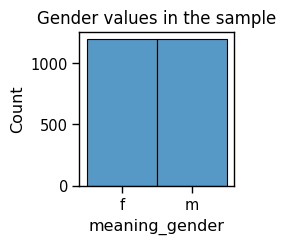

In [10]:
plt.figure(figsize=(2, 2))
sns.histplot(data["meaning_gender"])
plt.title("Gender values in the sample")
#plt.savefig(os.path.join(image_folder, "distr_gender.png"), bbox_inches="tight", dpi=DPI)
plt.show()

In [11]:
ratio_F = data["meaning_gender"].value_counts()["f"] / data["meaning_gender"].count()
print(f"label F: {data['meaning_gender'].value_counts()['f']} ({round(ratio_F*100)}%)")
print(f"label M: {data['meaning_gender'].value_counts()['m']} ({round((1-ratio_F)*100)}%)")

label F: 1195 (50%)
label M: 1195 (50%)


#### Last vowel / consonant

In [11]:
def plot_last_distribution(feature, title, FIGSIZE):
    if FIGSIZE:
        plt.figure(figsize=FIGSIZE)
    sns.histplot(pd.Categorical(data[feature], vowels))
    plt.title(f"‘{title}’ values")
    plt.savefig(os.path.join(image_folder, f"distr_{feature}.png"), bbox_inches="tight", dpi=DPI)
    plt.savefig(os.path.join(image_folder, f"distr_{feature}.pdf"), bbox_inches="tight", dpi=DPI)
    plt.show()


def plot_last_across_gender(feature, title, chi_p=0.05, FIGSIZE=None):
    last_gender = data.groupby(by=[feature, "meaning_gender"])["meaning_gender"].size().unstack(fill_value=0)
    last_gender["f_perc"] = round(last_gender["f"] / (last_gender["f"] + last_gender["m"]), 2)
    last_gender["m_perc"] = round(last_gender["m"] / (last_gender["f"] + last_gender["m"]), 2)
    last_gender = last_gender.sort_values("f_perc", ascending=False)
    
    last_gender["sum"] = last_gender["f"] + last_gender["m"]
    last_gender["f_exp"] = round(last_gender["sum"] * ratio_F)
    last_gender["m_exp"] = round(last_gender["sum"] - last_gender["f_exp"])
    
    last_gender["pvalue"] = [round(chisquare(
        f_obs=(vowel[1]["f"], vowel[1]["m"]),
        f_exp=(vowel[1]["f_exp"], vowel[1]["m_exp"])).pvalue, 4) for vowel in last_gender.iterrows()]
    last_gender = last_gender[last_gender["pvalue"]<=chi_p]

    last_gender["f"], last_gender["m"], last_gender["f_abs"], last_gender["m_abs"] = last_gender["f_perc"], last_gender["m_perc"], last_gender["f"], last_gender["m"]

    if FIGSIZE:
        plt.figure(figsize=FIGSIZE)
    sns.heatmap(last_gender[["f", "m"]].T, annot=last_gender[["f_abs", "m_abs"]].T, fmt="g", vmin=0, vmax=1)
    plt.title(f"‘{title}’ values")
    plt.savefig(os.path.join(image_folder, f"heatmap_{feature}_gender.png"), bbox_inches='tight', dpi=DPI)
    plt.savefig(os.path.join(image_folder, f"heatmap_{feature}_gender.pdf"), bbox_inches='tight', dpi=DPI)
    plt.show()

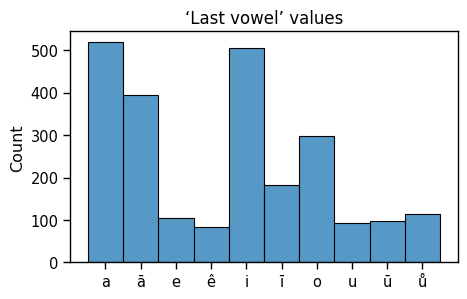

In [12]:
plot_last_distribution("last_vowel", "Last vowel", (5, 3))

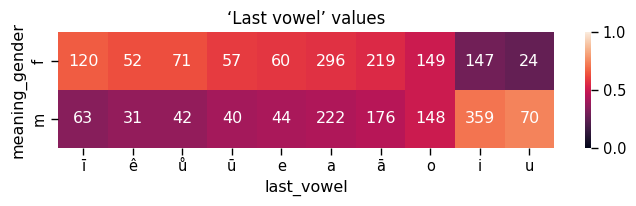

In [13]:
plot_last_across_gender("last_vowel", "Last vowel", 1, (8, 1.5))

#### Last N

In [15]:
def get_popular_endings(feature, endings_max=30, n_min=20):
    popular_endings = data[feature].value_counts()[:endings_max]
    return popular_endings[popular_endings>n_min]


def plot_endings(endings, feature, title, FIGSIZE=None):
    if FIGSIZE:
        plt.figure(figsize=FIGSIZE)
    sns.barplot(endings)
    plt.title(f"‘{title}’ values")
    plt.savefig(os.path.join(image_folder, f"distr_{feature}.png"), bbox_inches='tight', dpi=DPI)
    plt.savefig(os.path.join(image_folder, f"distr_{feature}.pdf"), bbox_inches='tight', dpi=DPI)
    plt.show()


def plot_endings_across_gender(popular_endings, feature, title, THRESHOLD=0.4, FIGSIZE=None):
    last_gender = data[data[feature].isin(popular_endings.keys())].groupby(by=[feature, "meaning_gender"])["meaning_gender"].size().unstack(fill_value=0)
    last_gender["f_perc"] = round(last_gender["f"] / (last_gender["f"] + last_gender["m"]), 2)
    last_gender["m_perc"] = round(last_gender["m"] / (last_gender["f"] + last_gender["m"]), 2)
    last_gender = last_gender[(last_gender["m_perc"]<THRESHOLD) | (last_gender["f_perc"]<THRESHOLD)].sort_values("f_perc", ascending=False)

    last_gender["f"], last_gender["m"], last_gender["f_abs"], last_gender["m_abs"] = last_gender["f_perc"], last_gender["m_perc"], last_gender["f"], last_gender["m"]
    
    if FIGSIZE:
        plt.figure(figsize=FIGSIZE)
    sns.heatmap(last_gender[["f", "m"]].T, annot=last_gender[["f_abs", "m_abs"]].T, fmt="g", vmin=0, vmax=1)
    plt.title(f"Most gendered ‘{title}’ values")
    plt.savefig(os.path.join(image_folder, f"heatmap_{feature}_gender.png"), bbox_inches='tight', dpi=DPI)
    plt.savefig(os.path.join(image_folder, f"heatmap_{feature}_gender.pdf"), bbox_inches='tight', dpi=DPI)
    plt.show()

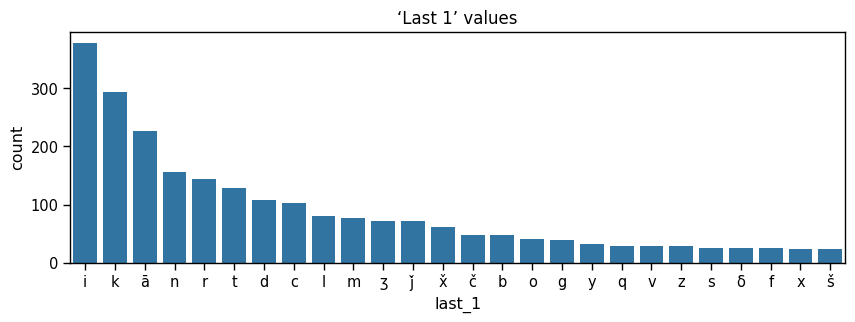

In [16]:
plot_endings(get_popular_endings("last_1"), "last_1", "Last 1", (10, 3))

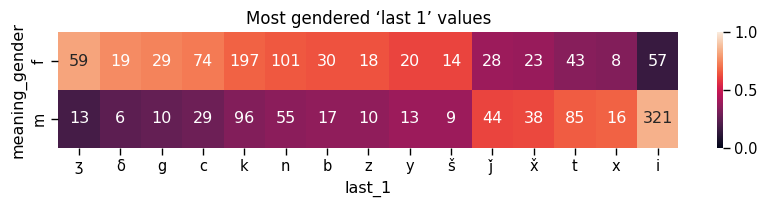

In [17]:
plot_endings_across_gender(get_popular_endings("last_1"), "last_1", "last 1", FIGSIZE=(10, 1.5))

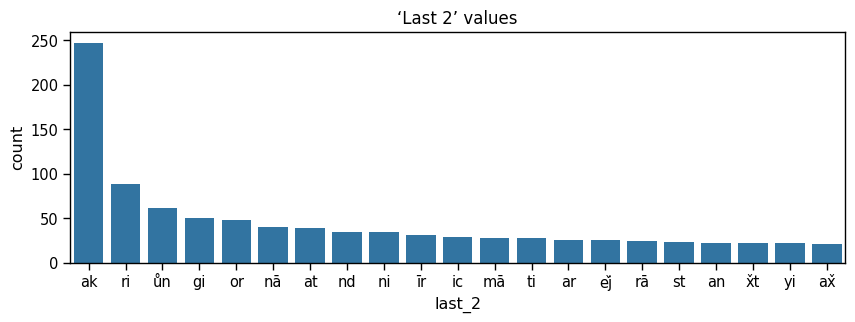

In [18]:
plot_endings(get_popular_endings("last_2"), "last_2", "Last 2", (10, 3))

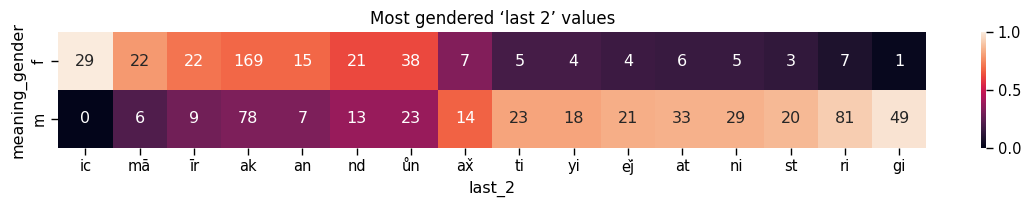

In [19]:
plot_endings_across_gender(get_popular_endings("last_2"), "last_2", "last 2", FIGSIZE=(14, 1.5))

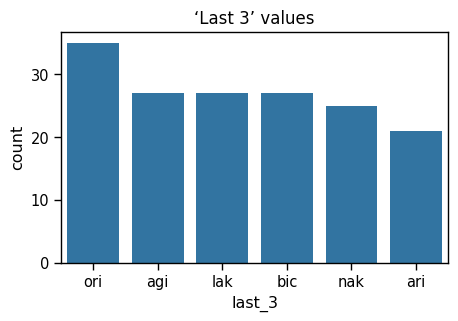

In [20]:
plot_endings(get_popular_endings("last_3"), "last_3", "Last 3", (5, 3))

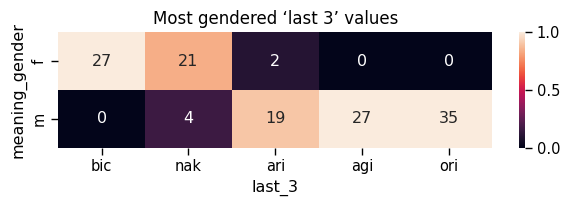

In [21]:
plot_endings_across_gender(get_popular_endings("last_3"), "last_3", "last 3", FIGSIZE=(7, 1.5))

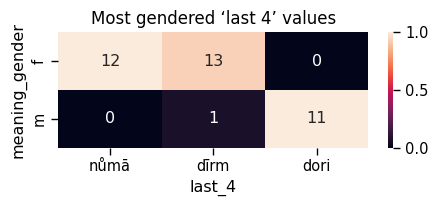

In [22]:
plot_endings_across_gender(get_popular_endings("last_4", endings_max=50, n_min=10), "last_4", "last 4", FIGSIZE=(5, 1.5))

#### Semantic features

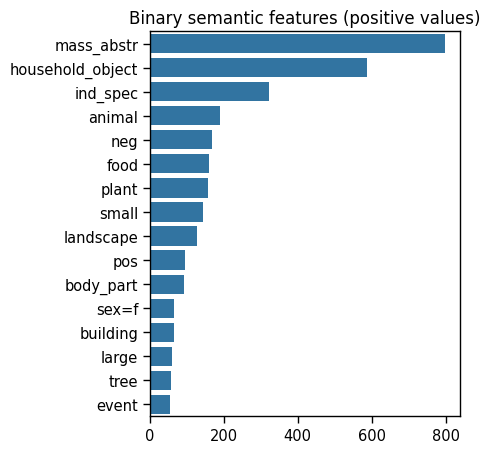

In [23]:
def plot_semantic_features(features, FIGSIZE=(4, 5)):
    stats = {}
    for feature in features:
        if len(data[data[feature]==1]) > 50:
            stats[feature] = data[feature].value_counts()[1]

    stats = {k: v for k, v in sorted(stats.items(), key=lambda item: item[1], reverse=True)}
    plt.figure(figsize=FIGSIZE)
    sns.barplot(stats, orient="h")
    plt.title(f"Binary semantic features (positive values)")
    plt.savefig(os.path.join(image_folder, f"distr_semantic.png"), bbox_inches="tight", dpi=DPI)
    plt.savefig(os.path.join(image_folder, f"distr_semantic.pdf"), bbox_inches="tight", dpi=DPI)
    plt.show()

plot_semantic_features(sem_features)

In [25]:
def plot_semantic_feature_across_gender(feature, FIGSIZE=(2, 2)):
    sem_gender = data.groupby(by=[feature, "meaning_gender"])["meaning_gender"].size().unstack(fill_value=0)
    sem_gender["f_perc"] = round(sem_gender["f"] / (sem_gender["f"] + sem_gender["m"]), 2)
    sem_gender["m_perc"] = round(sem_gender["m"] / (sem_gender["f"] + sem_gender["m"]), 2)
    sem_gender = sem_gender.sort_values(feature, ascending=True)

    sem_gender["f"], sem_gender["m"], sem_gender["f_abs"], sem_gender["m_abs"] = sem_gender["f_perc"], sem_gender["m_perc"], sem_gender["f"], sem_gender["m"]
    
    plt.figure(figsize=FIGSIZE)
    sns.heatmap(sem_gender[["f", "m"]].T, annot=sem_gender[["f_abs", "m_abs"]].T, fmt="g", vmin=0, vmax=1)
    plt.title(f"Gender across ‘{feature}’ feature")
    plt.savefig(os.path.join(image_folder, f"heatmap_{feature}.png"), bbox_inches='tight', dpi=DPI)
    #plt.savefig(os.path.join(image_folder, f"heatmap_{feature}.pdf"), bbox_inches='tight', dpi=DPI)
    plt.show()

In [ ]:
for sem_feature in sem_features:
    plot_semantic_feature_across_gender(sem_feature)

In [26]:
def plot_all_semantic_features_across_gender(features, FIGSIZE=(10, 3)):
    stats = {}
    for feature in features:
        positive = data[data[feature] == 1]
        stats[feature] = {}
        stats[feature]["f"] = positive["meaning_gender"].value_counts()["f"]
        stats[feature]["m"] = positive["meaning_gender"].value_counts()["m"]

    stats = pd.DataFrame(stats).T
    stats["f_perc"] = stats["f"] / (stats["f"] + stats["m"])
    stats = stats.sort_values(by="f_perc", ascending=False).drop("f_perc", axis=1)
    stats = stats.melt(var_name="gender", value_name="n", ignore_index=False)
    stats = stats.reset_index().rename(columns={"index": "feature"})
    plt.figure(figsize=FIGSIZE)
    sns.barplot(data=stats, x="feature", y="n", hue="gender")
    plt.xticks(rotation=40, ha="right")
    plt.title(f"Binary semantic features (positive values)")
    plt.savefig(os.path.join(image_folder, f"distr_semantic_gender.png"), bbox_inches="tight", dpi=DPI)
    plt.savefig(os.path.join(image_folder, f"distr_semantic_gender.pdf"), bbox_inches="tight", dpi=DPI)
    plt.show()

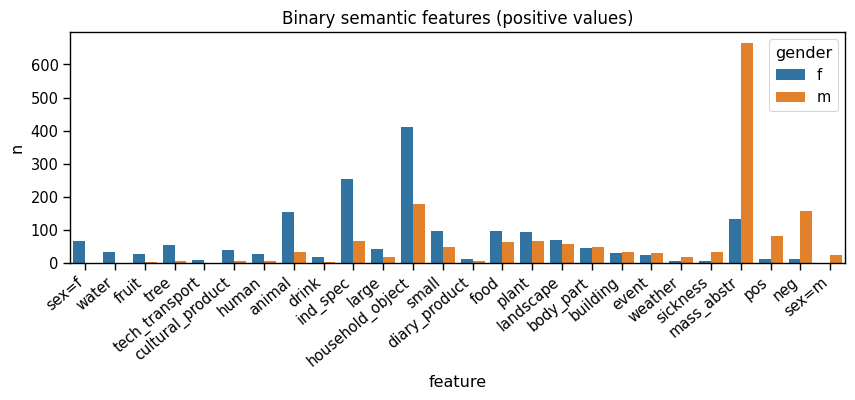

In [27]:
plot_all_semantic_features_across_gender(sem_features)

#### Morphological features

In [ ]:
for morph_feature in morph_features:
    plot_semantic_feature_across_gender(morph_feature)

#### Meanings

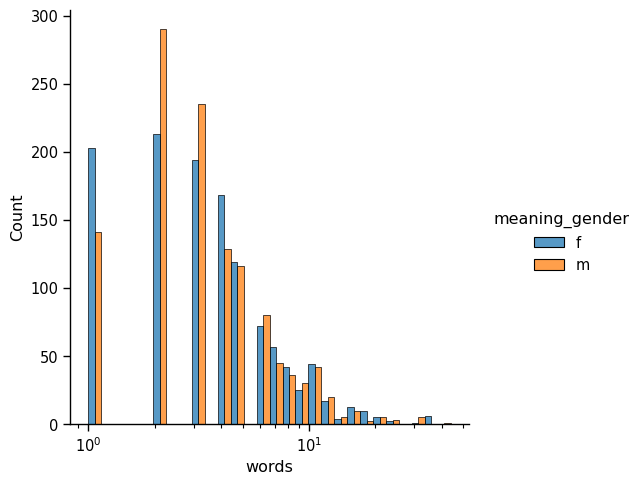

In [28]:
m = data[["meaning_gender", "meanings_concatenated"]]
m["words"] = m["meanings_concatenated"].apply(str.split)
m["words"] = m["words"].apply(len)

sns.displot(m, x="words", hue="meaning_gender", multiple="dodge", log_scale=True)

## Training preparation

### Training and transformation functions

In [12]:
def fit_predict(model, X_train, y_train, X_test, y_test):
    model.fit(X_train, y_train)
    _y_pred = model.predict(X_test)
    return _y_pred, classification_report(y_test, _y_pred, output_dict=True)


def train_models(X_train, y_train, X_test, y_test, model, settings, tuned_params=False):

    if model=="MNB":
        _model = MultinomialNB(
            alpha=settings["MNB_ALPHA"],
            fit_prior=True,
        )
        try:
            _y_pred, _results = fit_predict(
                _model, X_train, y_train, X_test, y_test)
            _y_train_pred = _model.predict(X_train)
            _results["accuracy_train"] = accuracy_score(y_train, _y_train_pred)
        except ValueError:
            _y_pred, _y_train_pred, _results = None, None, None
    
    elif model=="LOG":
        _model = LogisticRegression(
            penalty=settings["LOG_PENALTY"],
            C=settings["LOG_C"],
            solver=settings["LOG_SOLVER"]
        )
        _y_pred, _results = fit_predict(
            _model, X_train, y_train, X_test, y_test)
        _y_train_pred = _model.predict(X_train)
        _results["accuracy_train"] = accuracy_score(y_train, _y_train_pred)
    
    elif model=="SGD":
        _model = SGDClassifier(
            penalty=settings["SGD_PENALTY"],
            alpha=settings["SGD_ALPHA"],
            learning_rate=settings["SGD_LR"]
        )
        _y_pred, _results = fit_predict(
            _model, X_train, y_train, X_test, y_test)
        _y_train_pred = _model.predict(X_train)
        _results["accuracy_train"] = accuracy_score(y_train, _y_train_pred)
    
    elif model=="RFC":
        _model = RandomForestClassifier(
            max_depth=settings["RFC_MAX_DEPTH"],
            min_samples_leaf=settings["RFC_MIN_SAMPLES_LEAF"]
        )
        _y_pred, _results = fit_predict(
            _model, X_train, y_train, X_test, y_test)
        _results["accuracy_train"] = _model.score(X_train, y_train)
    
    elif model=="DTC":
        _model = DecisionTreeClassifier(
            max_depth=settings["DTC_MAX_DEPTH"],
            min_samples_leaf=settings["DTC_MIN_SAMPLES_LEAF"],
            min_weight_fraction_leaf=0.001,
            min_impurity_decrease=settings["DTC_MIN_IMPURITY_DECREASE"]
        )
        _y_pred, _results = fit_predict(
            _model, X_train, y_train, X_test, y_test)
        _results["accuracy_train"] = _model.score(X_train, y_train)

    elif model=="CATB":
        _model = CatBoostClassifier(
            iterations=settings["CATB_ITERATIONS"],
            learning_rate=settings["CATB_LR"],
            depth=settings["CATB_DEPTH"],
            silent=True
        )
        _y_pred, _results = fit_predict(
            _model, X_train, y_train, X_test, y_test)
        _results["accuracy_train"] = _model.score(X_train, y_train)

    if _y_pred is not None:
        _y_pred = list(_y_pred)

    return _y_pred, _results, _model


def show_accuracy(results):
    return {key: round(results[key]["accuracy"], 4) for key in results.keys()}


def show_class_score(results, score_name):
    class_score = {}
    for key in results.keys():
        class_score[key] = {}
        for class_ in ("f", "m"):
            class_score[key][class_] = round(results[key][class_][score_name], 4) 
    return class_score


def show_overfitting(results, model):
    accs = {}
    accs["accuracy_test"] = round(results[model]["accuracy"], 4)
    if "accuracy_train" in results[model]:
        accs["accuracy_train"] = round(results[model]["accuracy_train"], 4)
    return accs


def show_importances(model, features, n=20):
    indices = np.argsort(model.feature_importances_)[::-1]
    importances = []
    for f in range(min(n, len(features))):
        importances.append({
            "feature": features[indices[f]],
            "importance": model.feature_importances_[indices[f]]
        })
    return pd.DataFrame(importances, index=range(1, min(n, len(features))+1))


def transform_VECTORIZER(feature):
    return CountVectorizer().fit_transform(data[feature])


def transform_average_vectors(feature):
    vectors = CountVectorizer().fit_transform(data[feature]).toarray()
    return np.array([
        vectors[i] / np.sum(vectors[i]) if np.sum(vectors[i]) > 0 else np.zeros(vectors.shape[1])
        for i in range(vectors.shape[0])
    ])


def transform_OHE(feature):
    ohe = OneHotEncoder()
    return ohe.fit_transform(data[[feature]]), ohe.get_feature_names_out()


def transform_FASTTEXT(feature):
    model_path = "fasttext_wiki_news_subwords_300.kv"
    if os.path.exists(model_path):
        model = KeyedVectors.load(model_path)
    else:
        model = api.load("fasttext-wiki-news-subwords-300")
        model.save(model_path)
    
    def vectorize_text(text):
        words = simple_preprocess(text, deacc=True)
        word_vectors = [model[word] for word in words if word in model]
        if not word_vectors:
            return np.zeros(model.vector_size)
        return np.mean(word_vectors, axis=0)
    
    return np.array([vectorize_text(text) for text in data[feature]])


def transform_x_vectors(vector_features, fasttext_features):
    for _FEATURE in vector_features:
        x_feature_values[_FEATURE] = transform_VECTORIZER(_FEATURE)
    for _FEATURE in fasttext_features:
        x_feature_values[_FEATURE+"_fasttext"] = transform_FASTTEXT(_FEATURE)


def transform_x_phon_features(_phon_features):
    for _FEATURE in _phon_features:
        x_feature_values[_FEATURE], _vowels_feature_names = transform_OHE(_FEATURE)
    return _vowels_feature_names


def transform_x_last(_last_N_features):
    _word_endings = {}
    if "grouped" in globals():
        if grouped == True:
            for _FEATURE in _last_N_features:
                x_feature_values[_FEATURE] = transform_average_vectors(_FEATURE)
        for _FEATURE in _last_N_features:
            x_feature_values[_FEATURE], _word_endings[_FEATURE] = transform_OHE(_FEATURE)
    else:
        for _FEATURE in _last_N_features:
            x_feature_values[_FEATURE], _word_endings[_FEATURE] = transform_OHE(_FEATURE)
    return _word_endings


def delete_small_variance(feature, THRESHOLD):
    init_len = x_feature_values[feature].shape[1]
    selector = VarianceThreshold(threshold=THRESHOLD)
    x_feature_values[feature] = selector.fit_transform(x_feature_values[feature])
    indices = selector.get_support(indices=True)
    end_len = x_feature_values[feature].shape[1]
    print(f"variance:  ‘{feature}’ {round((init_len-end_len)/init_len*100, 2)}% deleted ({init_len} —> {end_len})")
    return indices


def delete_collinear(feature, column_indices, THRESHOLD):
    
    matrix = x_feature_values[feature]
    if isinstance(matrix, csr_matrix):
        matrix = matrix.toarray()
    init_len = matrix.shape[1]
    corr_matrix = np.corrcoef(matrix, rowvar=False)
    local_indices_to_remove = set()
    
    if not isinstance(corr_matrix, np.float64):
        for i in tqdm(range(len(corr_matrix)), leave=False):
            for j in range(i):
                if abs(corr_matrix[i, j]) > THRESHOLD:
                    local_indices_to_remove.add(i)
    local_indices_to_remove = sorted(local_indices_to_remove)
    
    matrix = np.delete(matrix, local_indices_to_remove, axis=1)
    column_indices = [x for x in column_indices if not x in [column_indices[i] for i in local_indices_to_remove]]
        
    x_feature_values[feature] = csr_matrix(matrix)
    end_len = matrix.shape[1]
    print(f"collinear: ‘{feature}’ {round((init_len-end_len)/init_len*100, 2)}% deleted ({init_len} —> {end_len})")
    return column_indices


def select_feature_names(feature, indices):
    selected_feature_names = [NONVECTORIZED_FEATURE_NAMES[feature][i] for i in indices]
    if not isinstance(x_feature_values[feature], np.ndarray):
        x_feature_values[feature] = x_feature_values[feature].toarray()
    x_feature_values[feature] = pd.DataFrame(x_feature_values[feature], columns=selected_feature_names)

### Transforming _x_-values

In [13]:
x_feature_values = {}

#x_feature_values["morph_features"] = data[morph_features]

vowels_feature_names = list(transform_x_phon_features(["last_vowel"]))
x_feature_values["last_vowel"] = pd.DataFrame.sparse.from_spmatrix(x_feature_values["last_vowel"], columns=vowels_feature_names)

word_endings = transform_x_last(last_N_features)
word_endings = list(x for e in word_endings.values() for x in list(e))
x_feature_values["word_endings"] = hstack([x_feature_values[last_N] for last_N in last_N_features])
x_feature_values["word_endings"] = pd.DataFrame.sparse.from_spmatrix(x_feature_values["word_endings"], columns=word_endings)

for last_N in last_N_features:
    del x_feature_values[last_N]

x_feature_values["word_endings + last_vowel"] = np.column_stack([
    x_feature_values["word_endings"], x_feature_values["last_vowel"]])

transform_x_vectors(
    ["meaning", "meanings_concatenated", "meaning_with_examples"],
    ["meaning", "meanings_concatenated", "meaning_with_examples"])
x_feature_values["sem_features"] = data[sem_features]

x_feature_values["sem_features + word_endings"] = np.column_stack([x_feature_values["sem_features"],
                                                         x_feature_values["word_endings"]])

x_feature_values["sem_features + word_endings + last_vowel"] = np.column_stack([x_feature_values["sem_features"],
                                                                    x_feature_values["last_vowel"],
                                                                    x_feature_values["word_endings"]])
all_nonvectorized_feature_names = sem_features + vowels_feature_names + word_endings
x_feature_values["sem_features + word_endings + last_vowel"] = pd.DataFrame(x_feature_values["sem_features + word_endings + last_vowel"],
                                                                columns=all_nonvectorized_feature_names).astype(int)

NONVECTORIZED_FEATURE_NAMES = {
    "last_vowel": vowels_feature_names,
    "word_endings": word_endings,
    "word_endings + last_vowel": word_endings + vowels_feature_names,
    "sem_features": sem_features,
    "sem_features + word_endings": sem_features + word_endings,
    "sem_features + word_endings + last_vowel": all_nonvectorized_feature_names,
}

x_feature_values["sem_features + meanings_concatenated"] = hstack([x_feature_values["sem_features"],
                                                           x_feature_values["meanings_concatenated"]])

x_feature_values["all"] = hstack([x_feature_values["sem_features"],
                                  x_feature_values["meanings_concatenated"],
                                  x_feature_values["word_endings"],
                                  x_feature_values["last_vowel"]])

In [14]:
SELECT_FEATURES = True

if SELECT_FEATURES:
    for feature in tqdm(x_feature_values, desc="FEATURES"):
        
        remaining_indices = list(delete_small_variance(feature, THRESHOLD=0.0005))
        if feature in NONVECTORIZED_FEATURE_NAMES:
            select_feature_names(feature, remaining_indices)
        
        remaining_indices = list(delete_collinear(feature, remaining_indices, THRESHOLD=0.95))
        if feature in NONVECTORIZED_FEATURE_NAMES:
            select_feature_names(feature, remaining_indices)

selected = "" if SELECT_FEATURES else "_notselected"

FEATURES:   0%|          | 0/14 [00:00<?, ?it/s]

variance:  ‘last_vowel’ 0.0% deleted (10 —> 10)


  0%|          | 0/10 [00:00<?, ?it/s]

collinear: ‘last_vowel’ 0.0% deleted (10 —> 10)
variance:  ‘word_endings’ 64.12% deleted (2924 —> 1049)


  0%|          | 0/1049 [00:00<?, ?it/s]

collinear: ‘word_endings’ 13.63% deleted (1049 —> 906)
variance:  ‘word_endings + last_vowel’ 63.91% deleted (2934 —> 1059)


  0%|          | 0/1059 [00:00<?, ?it/s]

collinear: ‘word_endings + last_vowel’ 13.5% deleted (1059 —> 916)
variance:  ‘meaning’ 71.0% deleted (4473 —> 1297)


  0%|          | 0/1297 [00:00<?, ?it/s]

collinear: ‘meaning’ 6.25% deleted (1297 —> 1216)
variance:  ‘meanings_concatenated’ 64.43% deleted (5161 —> 1836)


  0%|          | 0/1836 [00:00<?, ?it/s]

collinear: ‘meanings_concatenated’ 18.52% deleted (1836 —> 1496)
variance:  ‘meaning_with_examples’ 63.6% deleted (8920 —> 3247)


  0%|          | 0/3247 [00:00<?, ?it/s]

collinear: ‘meaning_with_examples’ 5.24% deleted (3247 —> 3077)
variance:  ‘meaning_fasttext’ 53.67% deleted (300 —> 139)


  0%|          | 0/139 [00:00<?, ?it/s]

collinear: ‘meaning_fasttext’ 22.3% deleted (139 —> 108)
variance:  ‘meanings_concatenated_fasttext’ 49.67% deleted (300 —> 151)


  0%|          | 0/151 [00:00<?, ?it/s]

collinear: ‘meanings_concatenated_fasttext’ 20.53% deleted (151 —> 120)
variance:  ‘meaning_with_examples_fasttext’ 45.0% deleted (300 —> 165)


  0%|          | 0/165 [00:00<?, ?it/s]

collinear: ‘meaning_with_examples_fasttext’ 14.55% deleted (165 —> 141)
variance:  ‘sem_features’ 0.0% deleted (26 —> 26)


  0%|          | 0/26 [00:00<?, ?it/s]

collinear: ‘sem_features’ 0.0% deleted (26 —> 26)
variance:  ‘sem_features + word_endings’ 63.56% deleted (2950 —> 1075)


  0%|          | 0/1075 [00:00<?, ?it/s]

collinear: ‘sem_features + word_endings’ 13.3% deleted (1075 —> 932)
variance:  ‘sem_features + word_endings + last_vowel’ 63.34% deleted (2960 —> 1085)


  0%|          | 0/1085 [00:00<?, ?it/s]

collinear: ‘sem_features + word_endings + last_vowel’ 13.18% deleted (1085 —> 942)
variance:  ‘sem_features + meanings_concatenated’ 64.1% deleted (5187 —> 1862)


  0%|          | 0/1862 [00:00<?, ?it/s]

collinear: ‘sem_features + meanings_concatenated’ 18.26% deleted (1862 —> 1522)
variance:  ‘all’ 64.03% deleted (8121 —> 2921)


  0%|          | 0/2921 [00:00<?, ?it/s]

collinear: ‘all’ 19.17% deleted (2921 —> 2361)


## Training

### Settings

In [15]:
SETTINGS = {
    "MNB_ALPHA": 0.5,
    "LOG_PENALTY": "l1",
    "LOG_C": 1.5,
    "LOG_SOLVER": "liblinear",
    "SGD_PENALTY": "l1",
    "SGD_ALPHA": 0.5,
    "SGD_LR": "optimal",
    "DTC_MAX_DEPTH": 50,
    "DTC_MIN_SAMPLES_LEAF": 10,               #   5
    "DTC_MIN_IMPURITY_DECREASE": 0.0005,
    "RFC_MAX_DEPTH": 50,
    "RFC_MIN_SAMPLES_LEAF": 10,               #   5
    "CATB_ITERATIONS": 100,
    "CATB_LR": 0.01,
    "CATB_DEPTH": 8
}

In [16]:
def TRAIN(FEATURES, _MODELS_TO_TRAIN):
    X_train, X_test, y_train, y_test = {}, {}, {}, {}
    
    for FEATURE in tqdm(FEATURES, desc="FEATURES"):
        X_train[FEATURE], X_test[FEATURE], y_pred[FEATURE], results[FEATURE],  models[FEATURE] = {}, {}, {}, {}, {}
        for MODEL in tqdm(_MODELS_TO_TRAIN, desc="MODELS", leave=False):
            y_pred[FEATURE][MODEL], results[FEATURE][MODEL], models[FEATURE][MODEL] = {}, {}, {}
            for rseed in RANDOM_SEEDS:
                X_train[FEATURE][rseed], X_test[FEATURE][rseed], y_train[rseed], y_test[rseed] = train_test_split(
                    x_feature_values[FEATURE], data["meaning_gender"], test_size=0.2,
                    random_state=rseed)
                y_pred[FEATURE][MODEL][rseed], results[FEATURE][MODEL][rseed], models[FEATURE][MODEL][rseed] = train_models(
                    X_train[FEATURE][rseed], y_train[rseed],
                    X_test[FEATURE][rseed], y_test[rseed],
                    MODEL, SETTINGS)
        print(f"{FEATURE} trained")

    for FEATURE in tqdm(FEATURES, desc="ANALYSIS"):
        mean_results[FEATURE] = {}
        for MODEL in _MODELS_TO_TRAIN:
            mean_results[FEATURE][MODEL] = {}
            for rseed in RANDOM_SEEDS:
                if results[FEATURE][MODEL][rseed] is None:
                    continue
                
                mean_results[FEATURE][MODEL][rseed] = {
                    "f_precision": results[FEATURE][MODEL][rseed]["f"]["precision"],
                    "f_recall": results[FEATURE][MODEL][rseed]["f"]["recall"],
                    "f_f1-score": results[FEATURE][MODEL][rseed]["f"]["f1-score"],
                    "m_precision": results[FEATURE][MODEL][rseed]["m"]["precision"],
                    "m_recall": results[FEATURE][MODEL][rseed]["m"]["recall"],
                    "m_f1-score": results[FEATURE][MODEL][rseed]["m"]["f1-score"],
                    "accuracy": results[FEATURE][MODEL][rseed]["accuracy"],
                    "precision": results[FEATURE][MODEL][rseed]["weighted avg"]["precision"],
                    "recall": results[FEATURE][MODEL][rseed]["weighted avg"]["recall"],
                    "f1-score": results[FEATURE][MODEL][rseed]["weighted avg"]["f1-score"]
                }
                
                for CLASS in ("m", "f"):
                    ys = pd.DataFrame({"y_test": y_test[rseed], "y_pred": y_pred[FEATURE][MODEL][rseed]})
                    ys = ys[ys["y_test"] == CLASS]
                    matrix = confusion_matrix(ys["y_test"], ys["y_pred"])
                    number = 0 if CLASS == "f" else 1
                    if len(matrix) == 1 and len(matrix[0]) == 1:
                        mean_results[FEATURE][MODEL][rseed][f"{CLASS}_accuracy"] = 1
                    else:
                        mean_results[FEATURE][MODEL][rseed][f"{CLASS}_accuracy"] = (matrix.diagonal()/matrix.sum(axis=1))[number]
            if len(mean_results[FEATURE][MODEL]) == 0:
                del mean_results[FEATURE][MODEL]

    for FEATURE in FEATURES:
        results[FEATURE] = {}
        for MODEL in _MODELS_TO_TRAIN:
            if MODEL in mean_results[FEATURE]:
                res_table = pd.DataFrame(mean_results[FEATURE][MODEL])
                results[FEATURE][MODEL], mean_results[FEATURE][MODEL] = {}, {}
                for row in res_table.index:
                    results[FEATURE][MODEL][row] = tuple(res_table.loc[row])
                    mean_results[FEATURE][MODEL][row] = {}
                    mean_results[FEATURE][MODEL][row]["mean"] = round(np.mean(results[FEATURE][MODEL][row]), 3)
                    mean_results[FEATURE][MODEL][row]["std"] = round(np.std(results[FEATURE][MODEL][row]), 3)
    return y_test

### Training on features

In [17]:
MODELS_TO_TRAIN = (
    "MNB",
    "LOG",
    #"SGD",
    "DTC",
    "RFC",
    "CATB"
)

In [18]:
print("FEATURES:", tuple(x_feature_values))
print("MODELS:", MODELS_TO_TRAIN)
y_test = TRAIN(x_feature_values, MODELS_TO_TRAIN)

FEATURES: ('last_vowel', 'word_endings', 'word_endings + last_vowel', 'meaning', 'meanings_concatenated', 'meaning_with_examples', 'meaning_fasttext', 'meanings_concatenated_fasttext', 'meaning_with_examples_fasttext', 'sem_features', 'sem_features + word_endings', 'sem_features + word_endings + last_vowel', 'sem_features + meanings_concatenated', 'all')
MODELS: ('MNB', 'LOG', 'DTC', 'RFC', 'CATB')


FEATURES:   0%|          | 0/14 [00:00<?, ?it/s]

MODELS:   0%|          | 0/5 [00:00<?, ?it/s]

last_vowel trained


MODELS:   0%|          | 0/5 [00:00<?, ?it/s]

word_endings trained


MODELS:   0%|          | 0/5 [00:00<?, ?it/s]

word_endings + last_vowel trained


MODELS:   0%|          | 0/5 [00:00<?, ?it/s]

meaning trained


MODELS:   0%|          | 0/5 [00:00<?, ?it/s]

meanings_concatenated trained


MODELS:   0%|          | 0/5 [00:00<?, ?it/s]

meaning_with_examples trained


MODELS:   0%|          | 0/5 [00:00<?, ?it/s]

meaning_fasttext trained


MODELS:   0%|          | 0/5 [00:00<?, ?it/s]

meanings_concatenated_fasttext trained


MODELS:   0%|          | 0/5 [00:00<?, ?it/s]

meaning_with_examples_fasttext trained


MODELS:   0%|          | 0/5 [00:00<?, ?it/s]

sem_features trained


MODELS:   0%|          | 0/5 [00:00<?, ?it/s]

sem_features + word_endings trained


MODELS:   0%|          | 0/5 [00:00<?, ?it/s]

sem_features + word_endings + last_vowel trained


MODELS:   0%|          | 0/5 [00:00<?, ?it/s]

sem_features + meanings_concatenated trained


MODELS:   0%|          | 0/5 [00:00<?, ?it/s]

all trained


ANALYSIS:   0%|          | 0/14 [00:00<?, ?it/s]

### Saving

In [19]:
for FEATURE in tqdm(x_feature_values.keys()):
    for MODEL in models[FEATURE]:
        for RSEED in models[FEATURE][MODEL]:
            joblib.dump(models[FEATURE][MODEL][RSEED], os.path.join(model_folder, f"model_{FEATURE}_{MODEL}_{RSEED}.pkl"))

with open("mean_results.json", "w", encoding="utf-8-sig") as f:
    json.dump(mean_results, f, indent=2, ensure_ascii=False)

  0%|          | 0/14 [00:00<?, ?it/s]

In [20]:
predictions = {}

CALCULATE_MEAN_PREDICTIONS = True

for i, row in tqdm(data.iterrows()):
    predictions[i] = {}
    for FEATURE in x_feature_values:
        if FEATURE.endswith("fasttext"):
            continue
        PRED_FEATURE = f"pred_{FEATURE}"
        predictions[i][PRED_FEATURE] = []
        SEEDS_TO_CALCULATE = RANDOM_SEEDS if CALCULATE_MEAN_PREDICTIONS else (best_rseed,)
        for RSEED in SEEDS_TO_CALCULATE:
            if i in y_test[RSEED]:
                local_index = pd.Index(y_test[RSEED].index).get_loc(i)
                result = y_pred[FEATURE]["MNB"][RSEED][local_index]
                result = 1 if result == row["meaning_gender"] else 0
                predictions[i][PRED_FEATURE].append(result)
        if CALCULATE_MEAN_PREDICTIONS:
            if len(predictions[i][PRED_FEATURE]) < 3:
                del predictions[i][PRED_FEATURE]
                continue
            n_pred = len(predictions[i][PRED_FEATURE])
        predictions[i][PRED_FEATURE] = int(np.mean(predictions[i][PRED_FEATURE]))
    if predictions[i] == {}:
        del predictions[i]
        continue
    predictions[i]["n_predictions"] = n_pred

predictions = pd.DataFrame.from_dict(predictions, orient="index")
predictions = pd.merge(data, predictions, left_index=True, right_index=True)
predictions = predictions.drop(columns=["full_entry", "meanings_concatenated", "meaning_with_examples"])

predictions.to_csv("predictions.csv", index=False)

0it [00:00, ?it/s]

## Analysis

### Loading the results

In [38]:
models = {}
for FEATURE in tqdm(x_feature_values):
    models[FEATURE] = {}
    for MODEL in MODELS_TO_TRAIN:
        models[FEATURE][MODEL] = {}
        for RSEED in RANDOM_SEEDS:
            models[FEATURE][MODEL][RSEED] = joblib.load(os.path.join(model_folder, f"model_{FEATURE}_{MODEL}_{RSEED}.pkl"))

  0%|          | 0/16 [00:00<?, ?it/s]

In [39]:
with open("mean_results.json", "r", encoding="utf-8-sig") as f:
    mean_results = json.load(f)

In [40]:
predictions = pd.read_csv("predictions.csv")

### Metrics

#### Functions

In [22]:
def get_scores_all(metric, features_to_plot, models_to_plot, metric_type):
    scores = {}
    for feature_ in mean_results:
        if feature_ in features_to_plot:
            scores[feature_] = []
            for model_ in models_to_plot:
                if model_ in mean_results[feature_]:
                    scores[feature_].append(mean_results[feature_][model_][metric][metric_type])
                else:
                    scores[feature_].append(None)
    return pd.DataFrame(scores, index=models_to_plot).transpose()


def get_scores_by_class(metric, features_to_plot, models_to_plot, metric_type):
    class_scores = {}
    for class_ in ("f", "m"):
        class_scores[class_] = {}
        for feature_ in mean_results:
            if feature_ in features_to_plot:
                class_scores[class_][feature_] = {}
                for model_ in models_to_plot:
                    if model_ in mean_results[feature_]:
                        class_scores[class_][feature_][model_] = mean_results[feature_][model_][f"{class_}_{metric}"][metric_type]
                    else:
                        class_scores[class_][feature_][model_] = None
        class_scores[class_] = pd.DataFrame(class_scores[class_]).transpose()
    return class_scores


def plot_metric_all(metric, features_to_plot, models_to_plot, filename_suffix="", metric_type="mean"):
    if len(filename_suffix)>0:
        filename_suffix = "_"+filename_suffix
    scores = get_scores_all(metric, features_to_plot, models_to_plot, metric_type)
    
    plt.figure(figsize=(len(models_to_plot)*0.8, (len(features_to_plot)+2)//2))
    sns.heatmap(scores, vmin=0.5, vmax=1, annot=True, cbar=False, fmt=".2f")
    plt.title(f"Test {metric}")
    #plt.xticks(rotation=20, ha="right")
    plt.savefig(os.path.join(image_folder, f"metric_{metric}{filename_suffix}{selected}.png"), bbox_inches="tight", dpi=DPI)
    plt.savefig(os.path.join(image_folder, f"metric_{metric}{filename_suffix}{selected}.pdf"), bbox_inches="tight", dpi=DPI)
    plt.show()


def plot_metric_by_class(metric, features_to_plot, models_to_plot, filename_suffix="", metric_type="mean"):
    if len(filename_suffix)>0:
        filename_suffix = "_"+filename_suffix
    class_scores = get_scores_by_class(metric, features_to_plot, models_to_plot, metric_type)
    
    fig, axes = plt.subplots(ncols=2, figsize=(len(models_to_plot)*1.9, (len(features_to_plot)+2)//2))
    ax1, ax2 = axes
    sns.heatmap(class_scores["f"], vmin=0.5, vmax=1, annot=True, cbar=False, ax=ax1, fmt=".2f")
    sns.heatmap(class_scores["m"], vmin=0.5, vmax=1, annot=True, cbar=False, yticklabels=False, ax=ax2, fmt=".2f")
    ax1.set_title("true feminine")
    ax2.set_title("true masculine")
    fig.suptitle(f"Test {metric} by gender")
    fig.tight_layout()
    plt.savefig(os.path.join(image_folder, f"metric_{metric}_gender{filename_suffix}{selected}.png"), bbox_inches='tight', dpi=DPI)
    plt.savefig(os.path.join(image_folder, f"metric_{metric}_gender{filename_suffix}{selected}.pdf"), bbox_inches='tight', dpi=DPI)
    plt.show()


def plot_metric_class_n_all(metric, features_to_plot, models_to_plot, model="MNB", filename_suffix="", metric_type="mean"):
    if len(filename_suffix)>0:
        filename_suffix = "_"+filename_suffix
    class_scores = get_scores_by_class(metric, features_to_plot, models_to_plot, metric_type)
    class_scores["avg"] = get_scores_all(metric, features_to_plot, models_to_plot, metric_type)
    for key in class_scores:
        class_scores[key] = class_scores[key][model].T
        class_scores[key].name = key
    class_scores = pd.concat(class_scores, axis=1).dropna()
    
    plt.figure(figsize=(len(class_scores.columns)*0.8, (len(class_scores)+2)//2))
    sns.heatmap(class_scores, vmin=0.5, vmax=1, annot=True, cbar=False, fmt=".2f")
    plt.title(f"Test {metric} for {model}")
    #plt.xticks(rotation=20, ha="right")
    plt.savefig(os.path.join(image_folder, f"metric_{metric}{filename_suffix}{selected}.png"), bbox_inches="tight", dpi=DPI)
    plt.savefig(os.path.join(image_folder, f"metric_{metric}{filename_suffix}{selected}.pdf"), bbox_inches="tight", dpi=DPI)
    plt.show()

#### F1-score

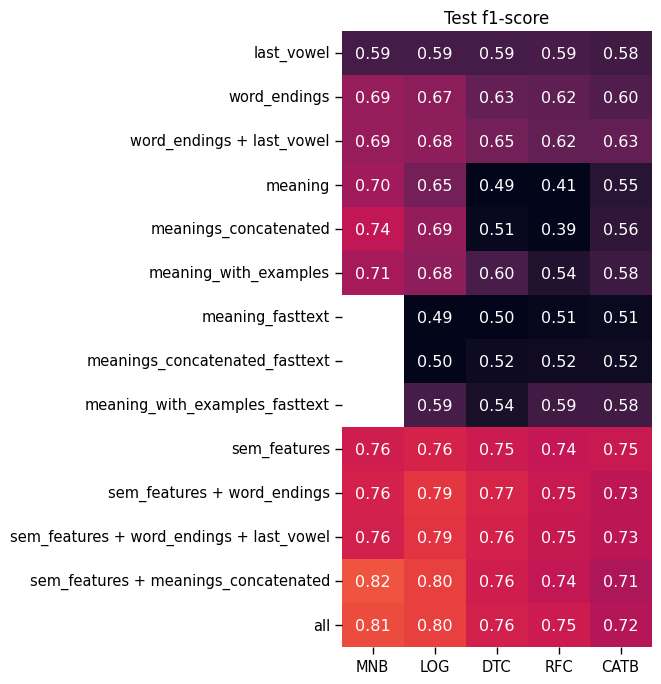

In [23]:
plot_metric_all("f1-score", x_feature_values, MODELS_TO_TRAIN, filename_suffix="full")

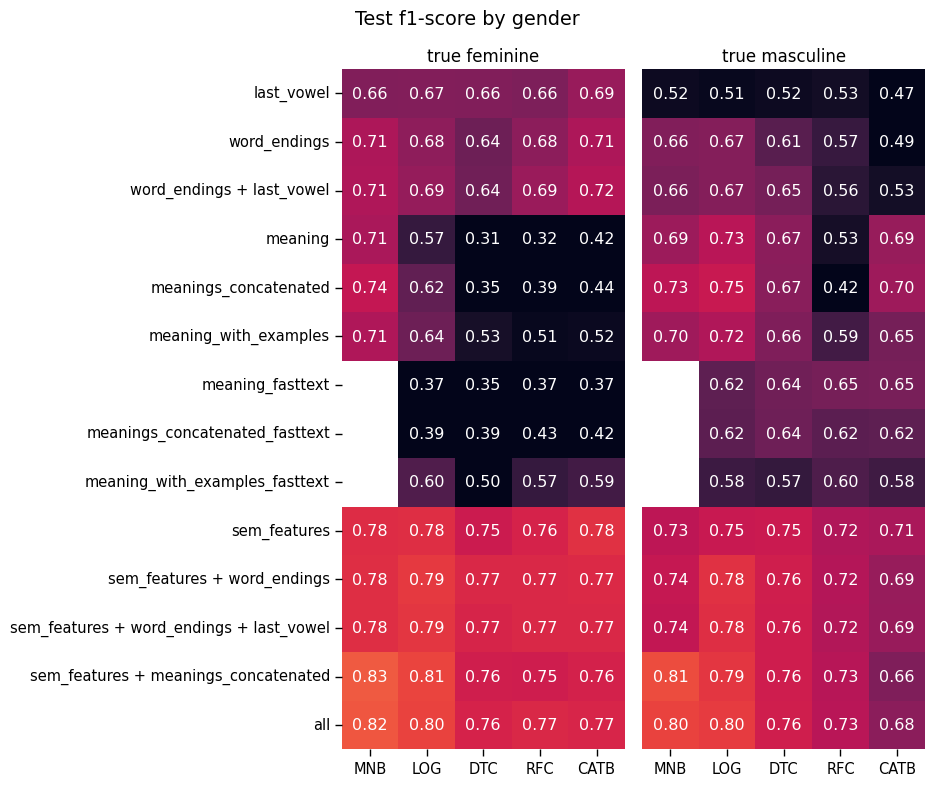

In [24]:
plot_metric_by_class("f1-score", x_feature_values, MODELS_TO_TRAIN, filename_suffix="full")

#### Specific plots

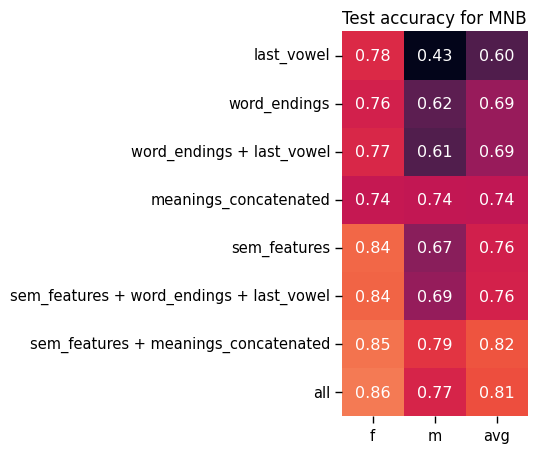

In [66]:
plot_metric_class_n_all("accuracy",
                        ["last_vowel", "word_endings", "word_endings + last_vowel",
                         "meanings_concatenated", "sem_features",
                         "sem_features + word_endings + last_vowel",
                         "sem_features + meanings_concatenated", "all"],
                        MODELS_TO_TRAIN, "MNB", filename_suffix="main")

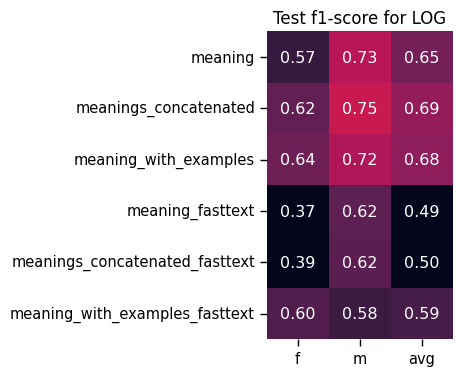

In [65]:
plot_metric_class_n_all("f1-score",
                        ["meaning", "meanings_concatenated", "meaning_with_examples",
                         "meaning_fasttext", "meanings_concatenated_fasttext", "meaning_with_examples_fasttext"],
                        MODELS_TO_TRAIN, "LOG", filename_suffix="meanings")

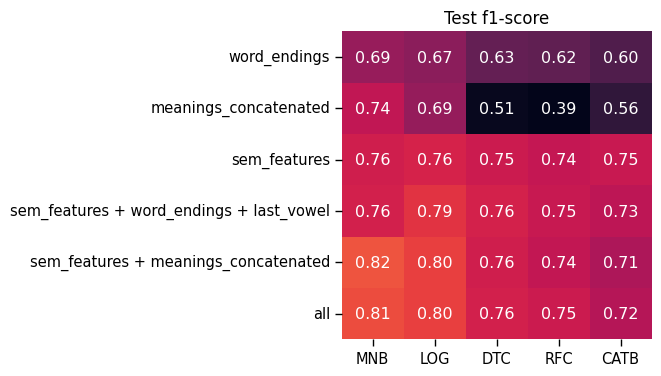

In [45]:
plot_metric_all("f1-score", ["word_endings",
                             "meanings_concatenated", "sem_features",
                             "sem_features + word_endings + last_vowel",
                             "sem_features + meanings_concatenated",
                             "all"], MODELS_TO_TRAIN, filename_suffix="models")

#### Confusion matrices

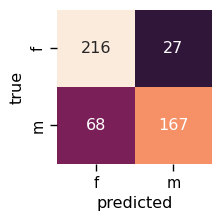

In [28]:
FEATURE = "sem_features"

plt.figure(figsize=(2,2))
conf = pd.DataFrame(confusion_matrix(y_test[42], y_pred[FEATURE]["MNB"][42], labels=["f", "m"]),
            columns=["f", "m"], index=["f", "m"])
ax = sns.heatmap(conf, vmin=0, annot=True, cbar=False, fmt=".0f")
plt.xlabel("predicted")
plt.ylabel("true")
plt.show()

#### Precision

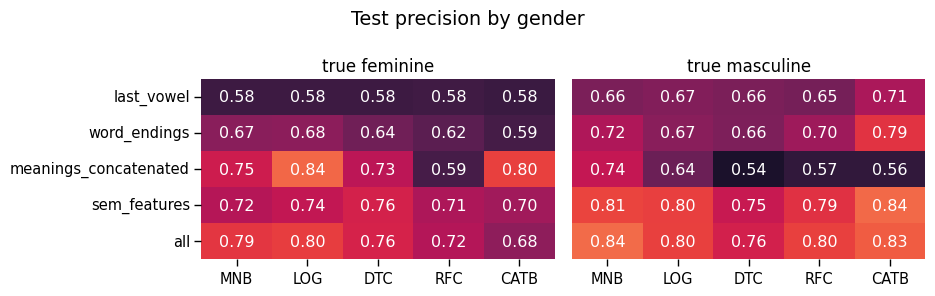

In [47]:
plot_metric_by_class("precision", ["last_vowel", "word_endings", "meanings_concatenated", "sem_features", "all"], MODELS_TO_TRAIN)

#### Recall

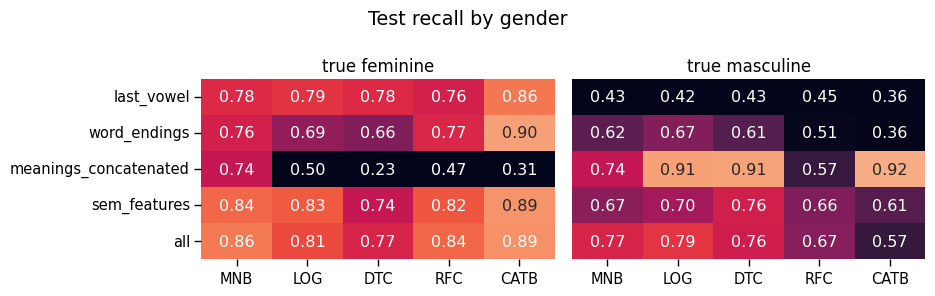

In [48]:
plot_metric_by_class("recall", ["last_vowel", "word_endings", "meanings_concatenated", "sem_features", "all"], MODELS_TO_TRAIN)

#### Accuracy

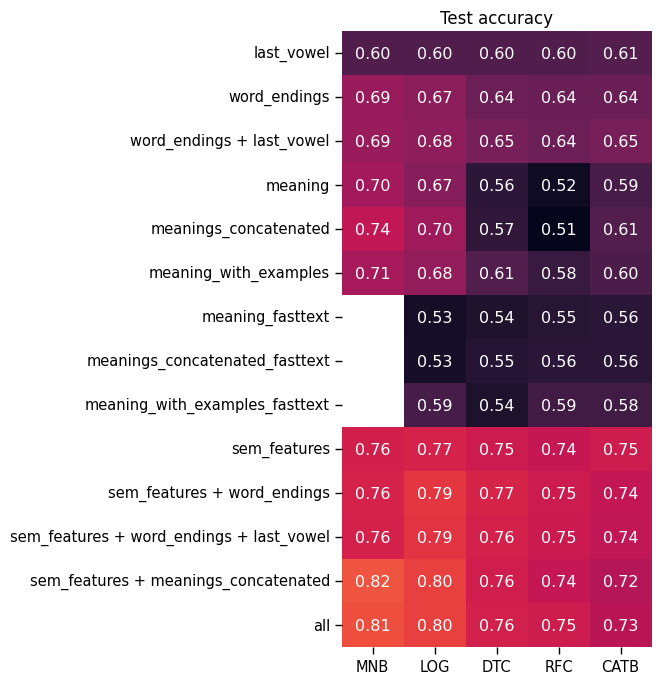

In [31]:
plot_metric_all("accuracy", x_feature_values, MODELS_TO_TRAIN, filename_suffix="full")

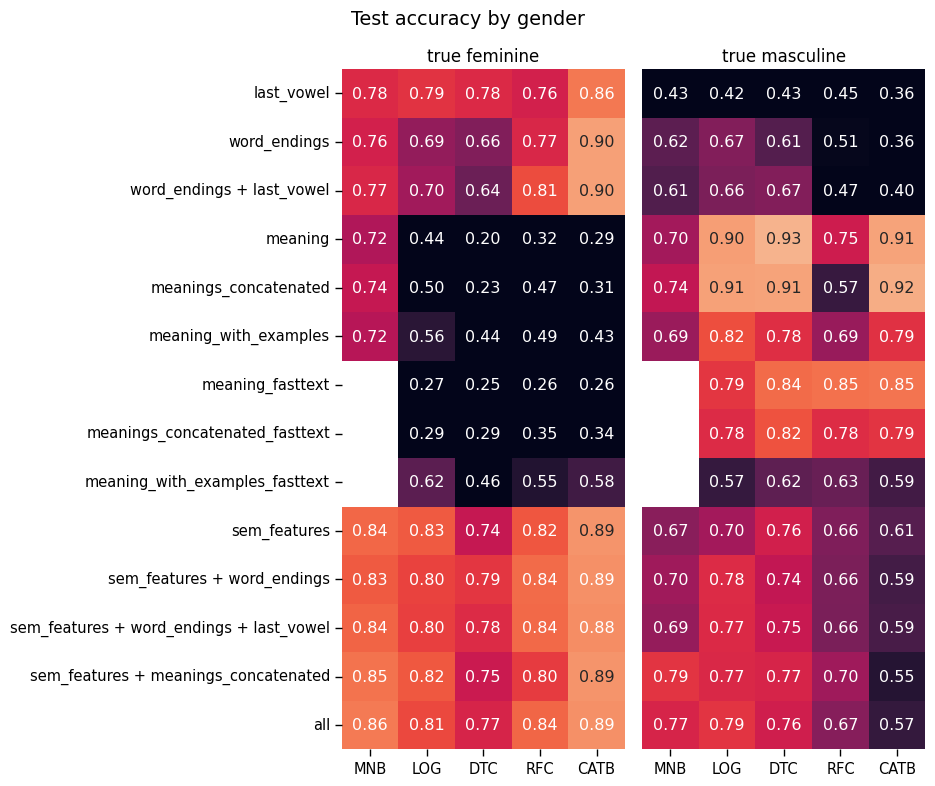

In [32]:
plot_metric_by_class("accuracy", x_feature_values, MODELS_TO_TRAIN, filename_suffix="full")

### Feature importances

In [34]:
def plot_RFC_importances(featuretype, max=25):
    RFC_importances = [show_importances(
        models[featuretype]["RFC"][rseed],
        NONVECTORIZED_FEATURE_NAMES[featuretype]).sort_values("feature").set_index("feature") for rseed in RANDOM_SEEDS]
    RFC_importances = pd.concat(RFC_importances, axis=1)
    RFC_importances.columns = [f"col{i}" for i in range(len(RFC_importances.columns))]
    RFC_importances = RFC_importances.mean(axis=1).sort_values(ascending=False)

    RFC_importances = RFC_importances[:max]
    
    plt.figure(figsize=(10 // (20 / len(RFC_importances)), 2))
    sns.barplot(RFC_importances)
    plt.xticks(rotation=40, ha="right")
    plt.suptitle(f"Most important features of class ‘{featuretype}’ for RFC (mean)")
    plt.savefig(os.path.join(image_folder, f"importances_RFC_{featuretype}{selected}.png"), bbox_inches='tight', dpi=DPI)
    plt.savefig(os.path.join(image_folder, f"importances_RFC_{featuretype}{selected}.pdf"), bbox_inches='tight', dpi=DPI)
    plt.show()

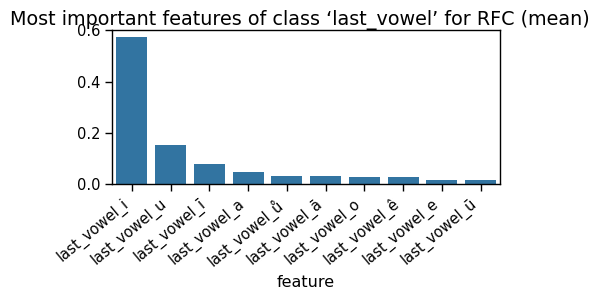

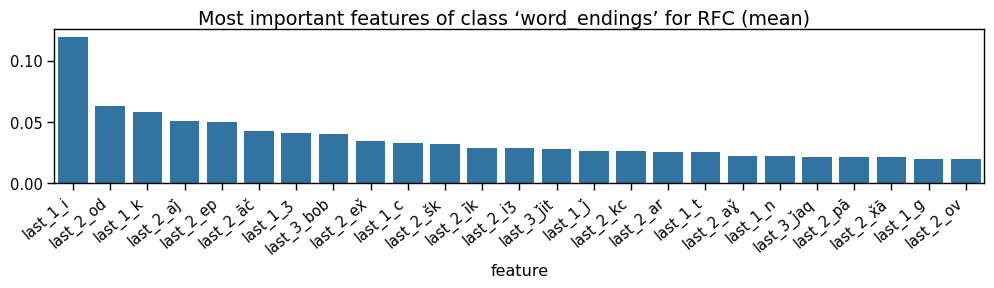

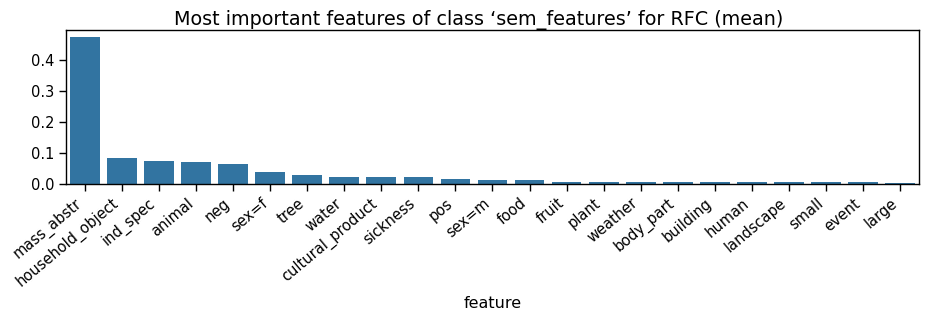

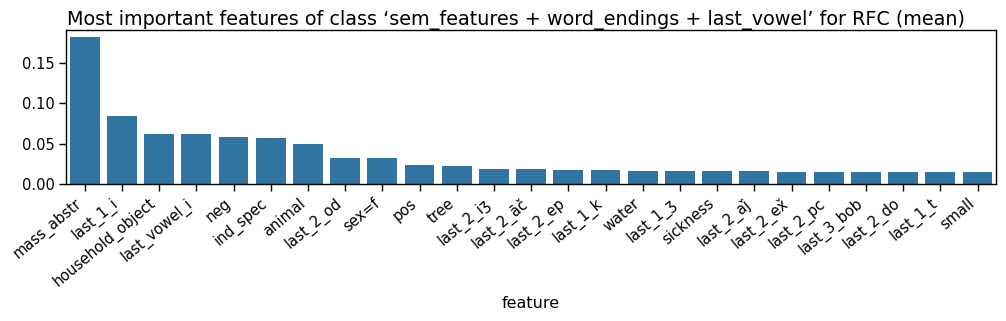

In [50]:
if "RFC" in MODELS_TO_TRAIN:
    for feature in ("last_vowel", "word_endings", "sem_features", "sem_features + word_endings + last_vowel"):
        plot_RFC_importances(feature)

### DTC Tree

In [36]:
def plot_dtc(featuretype):
    plt.figure(figsize=(35, 35))
    plot_tree(models[featuretype]["DTC"][RANDOM_SEEDS[0]], filled=True,
              feature_names=NONVECTORIZED_FEATURE_NAMES[featuretype],
              #max_depth=10,
              class_names=("f", "m"),
              impurity=False, label="none", fontsize=16)
    plt.suptitle(f"Decision tree for features of class ‘{featuretype}’ (mean)")
    plt.savefig(os.path.join(image_folder, f"DTC_tree_{featuretype}{selected}.pdf"), dpi=DPI//4)
    plt.show()

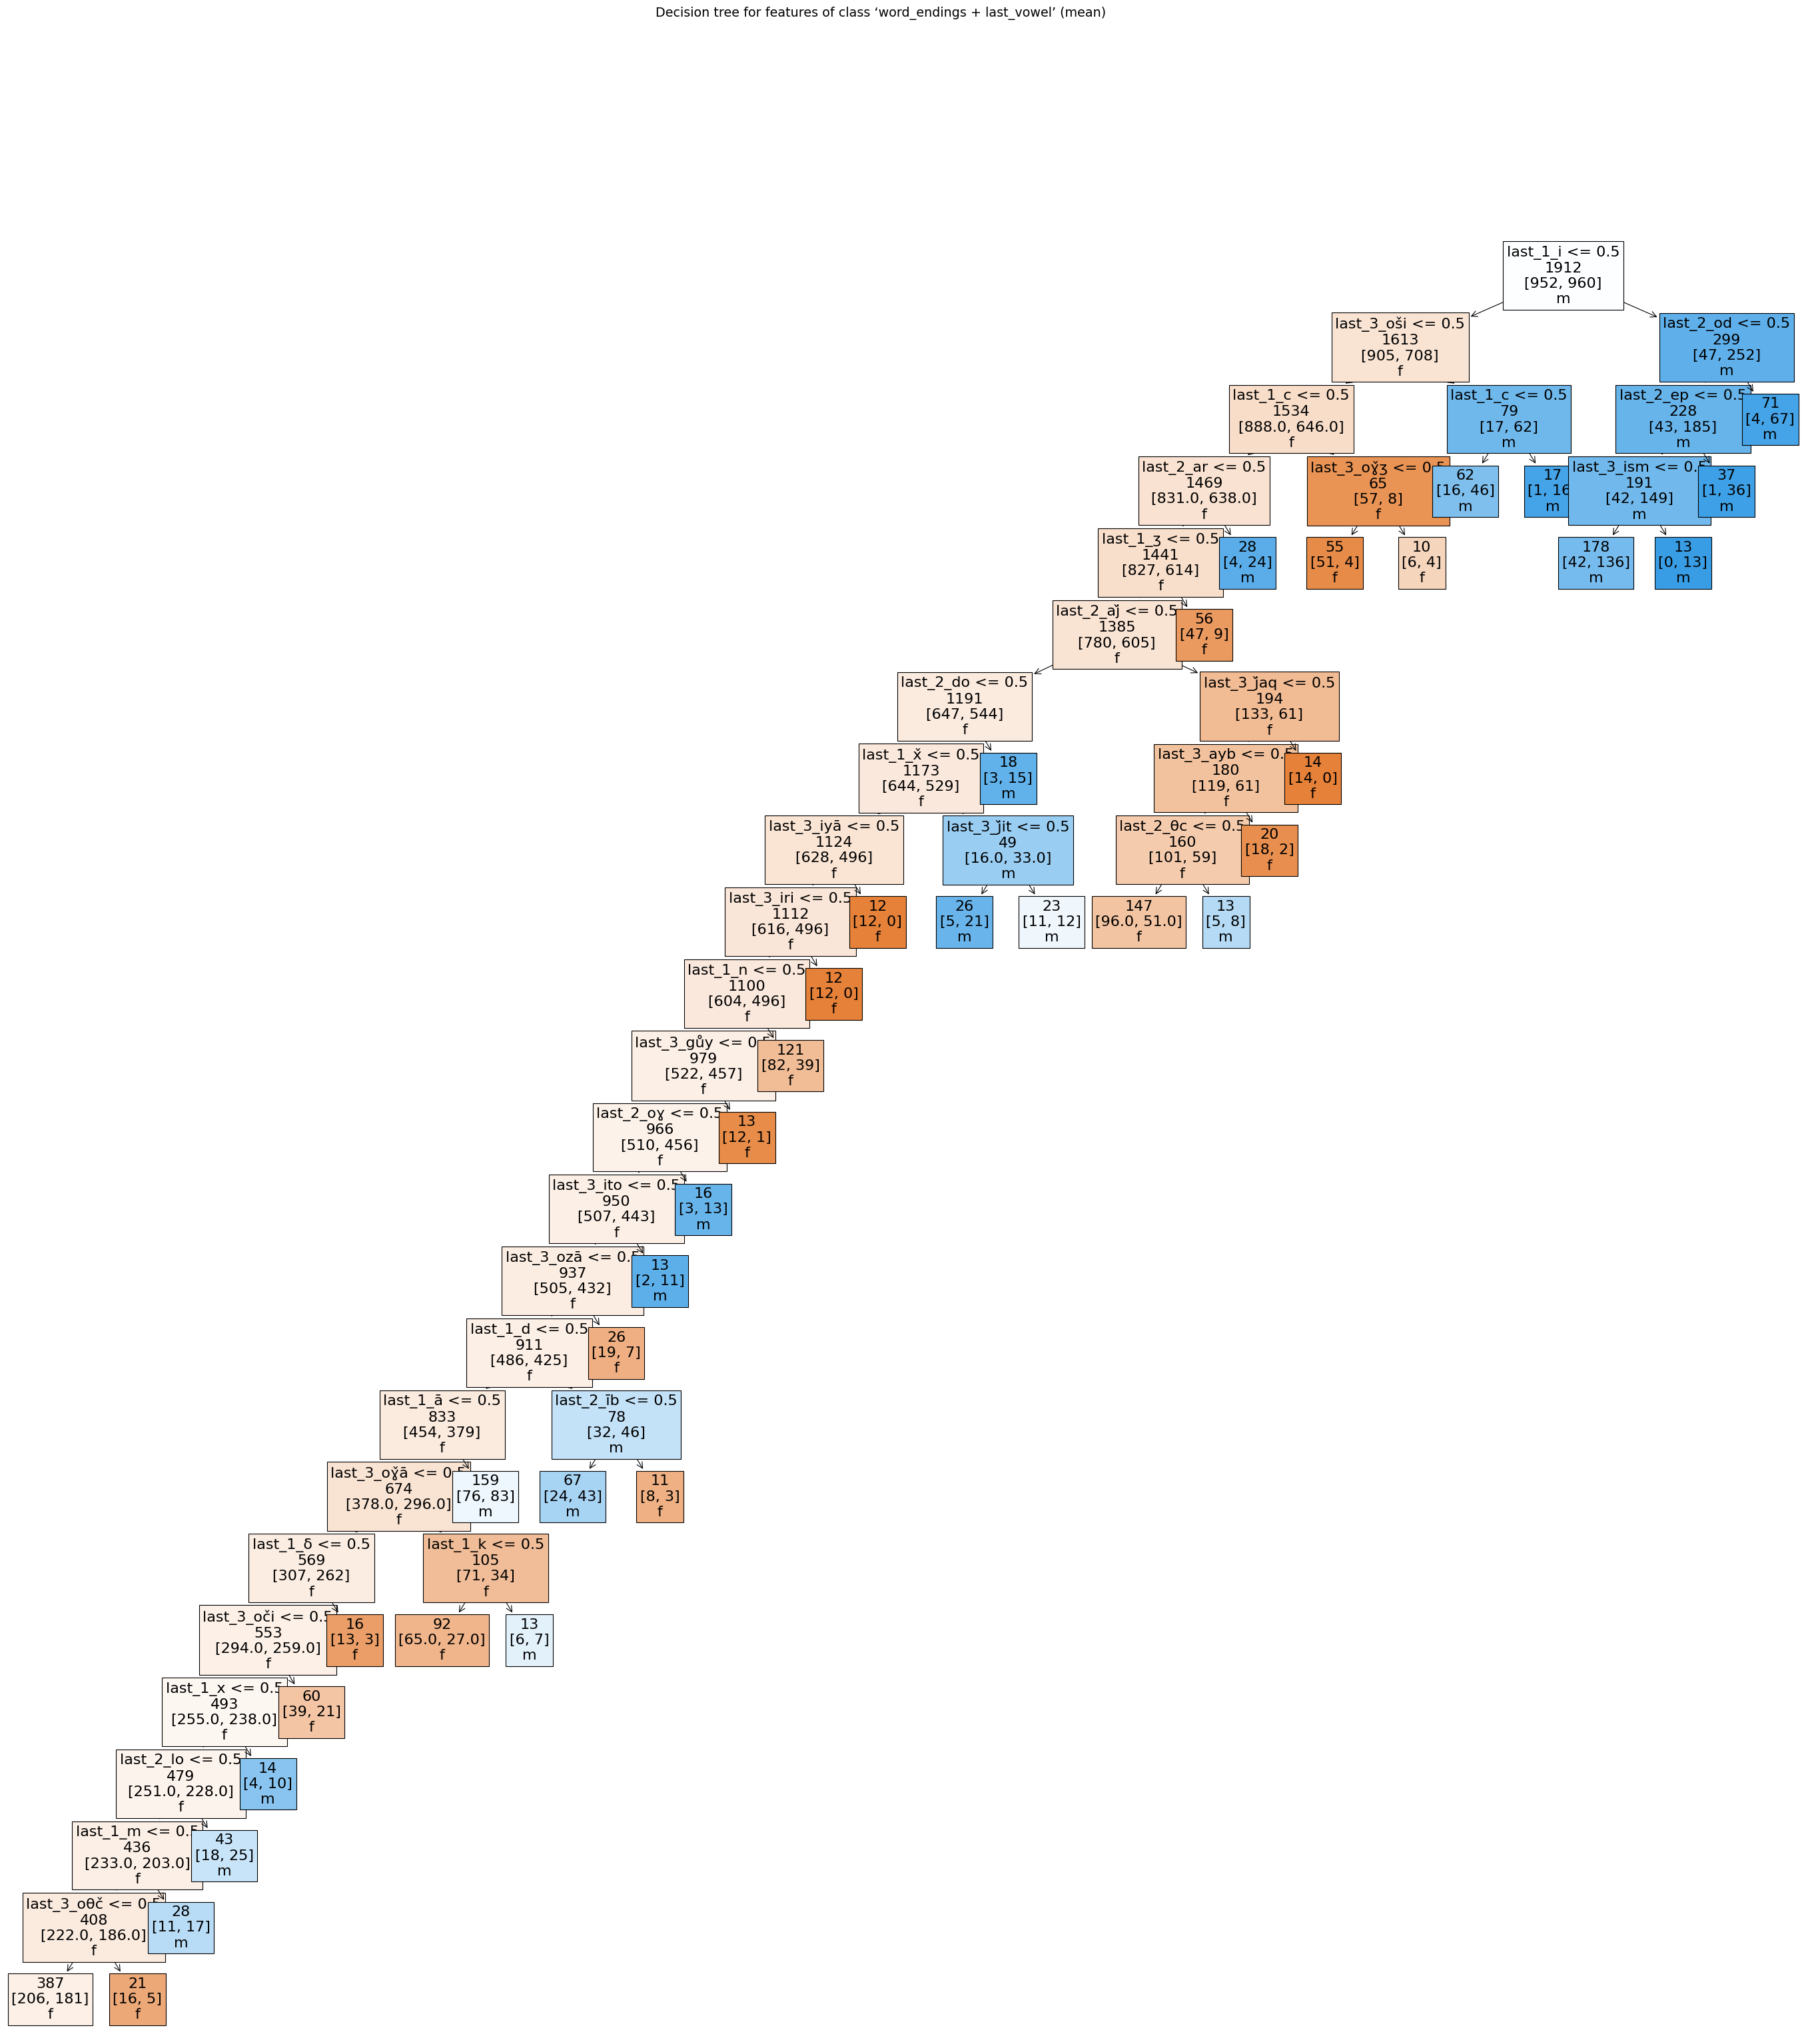

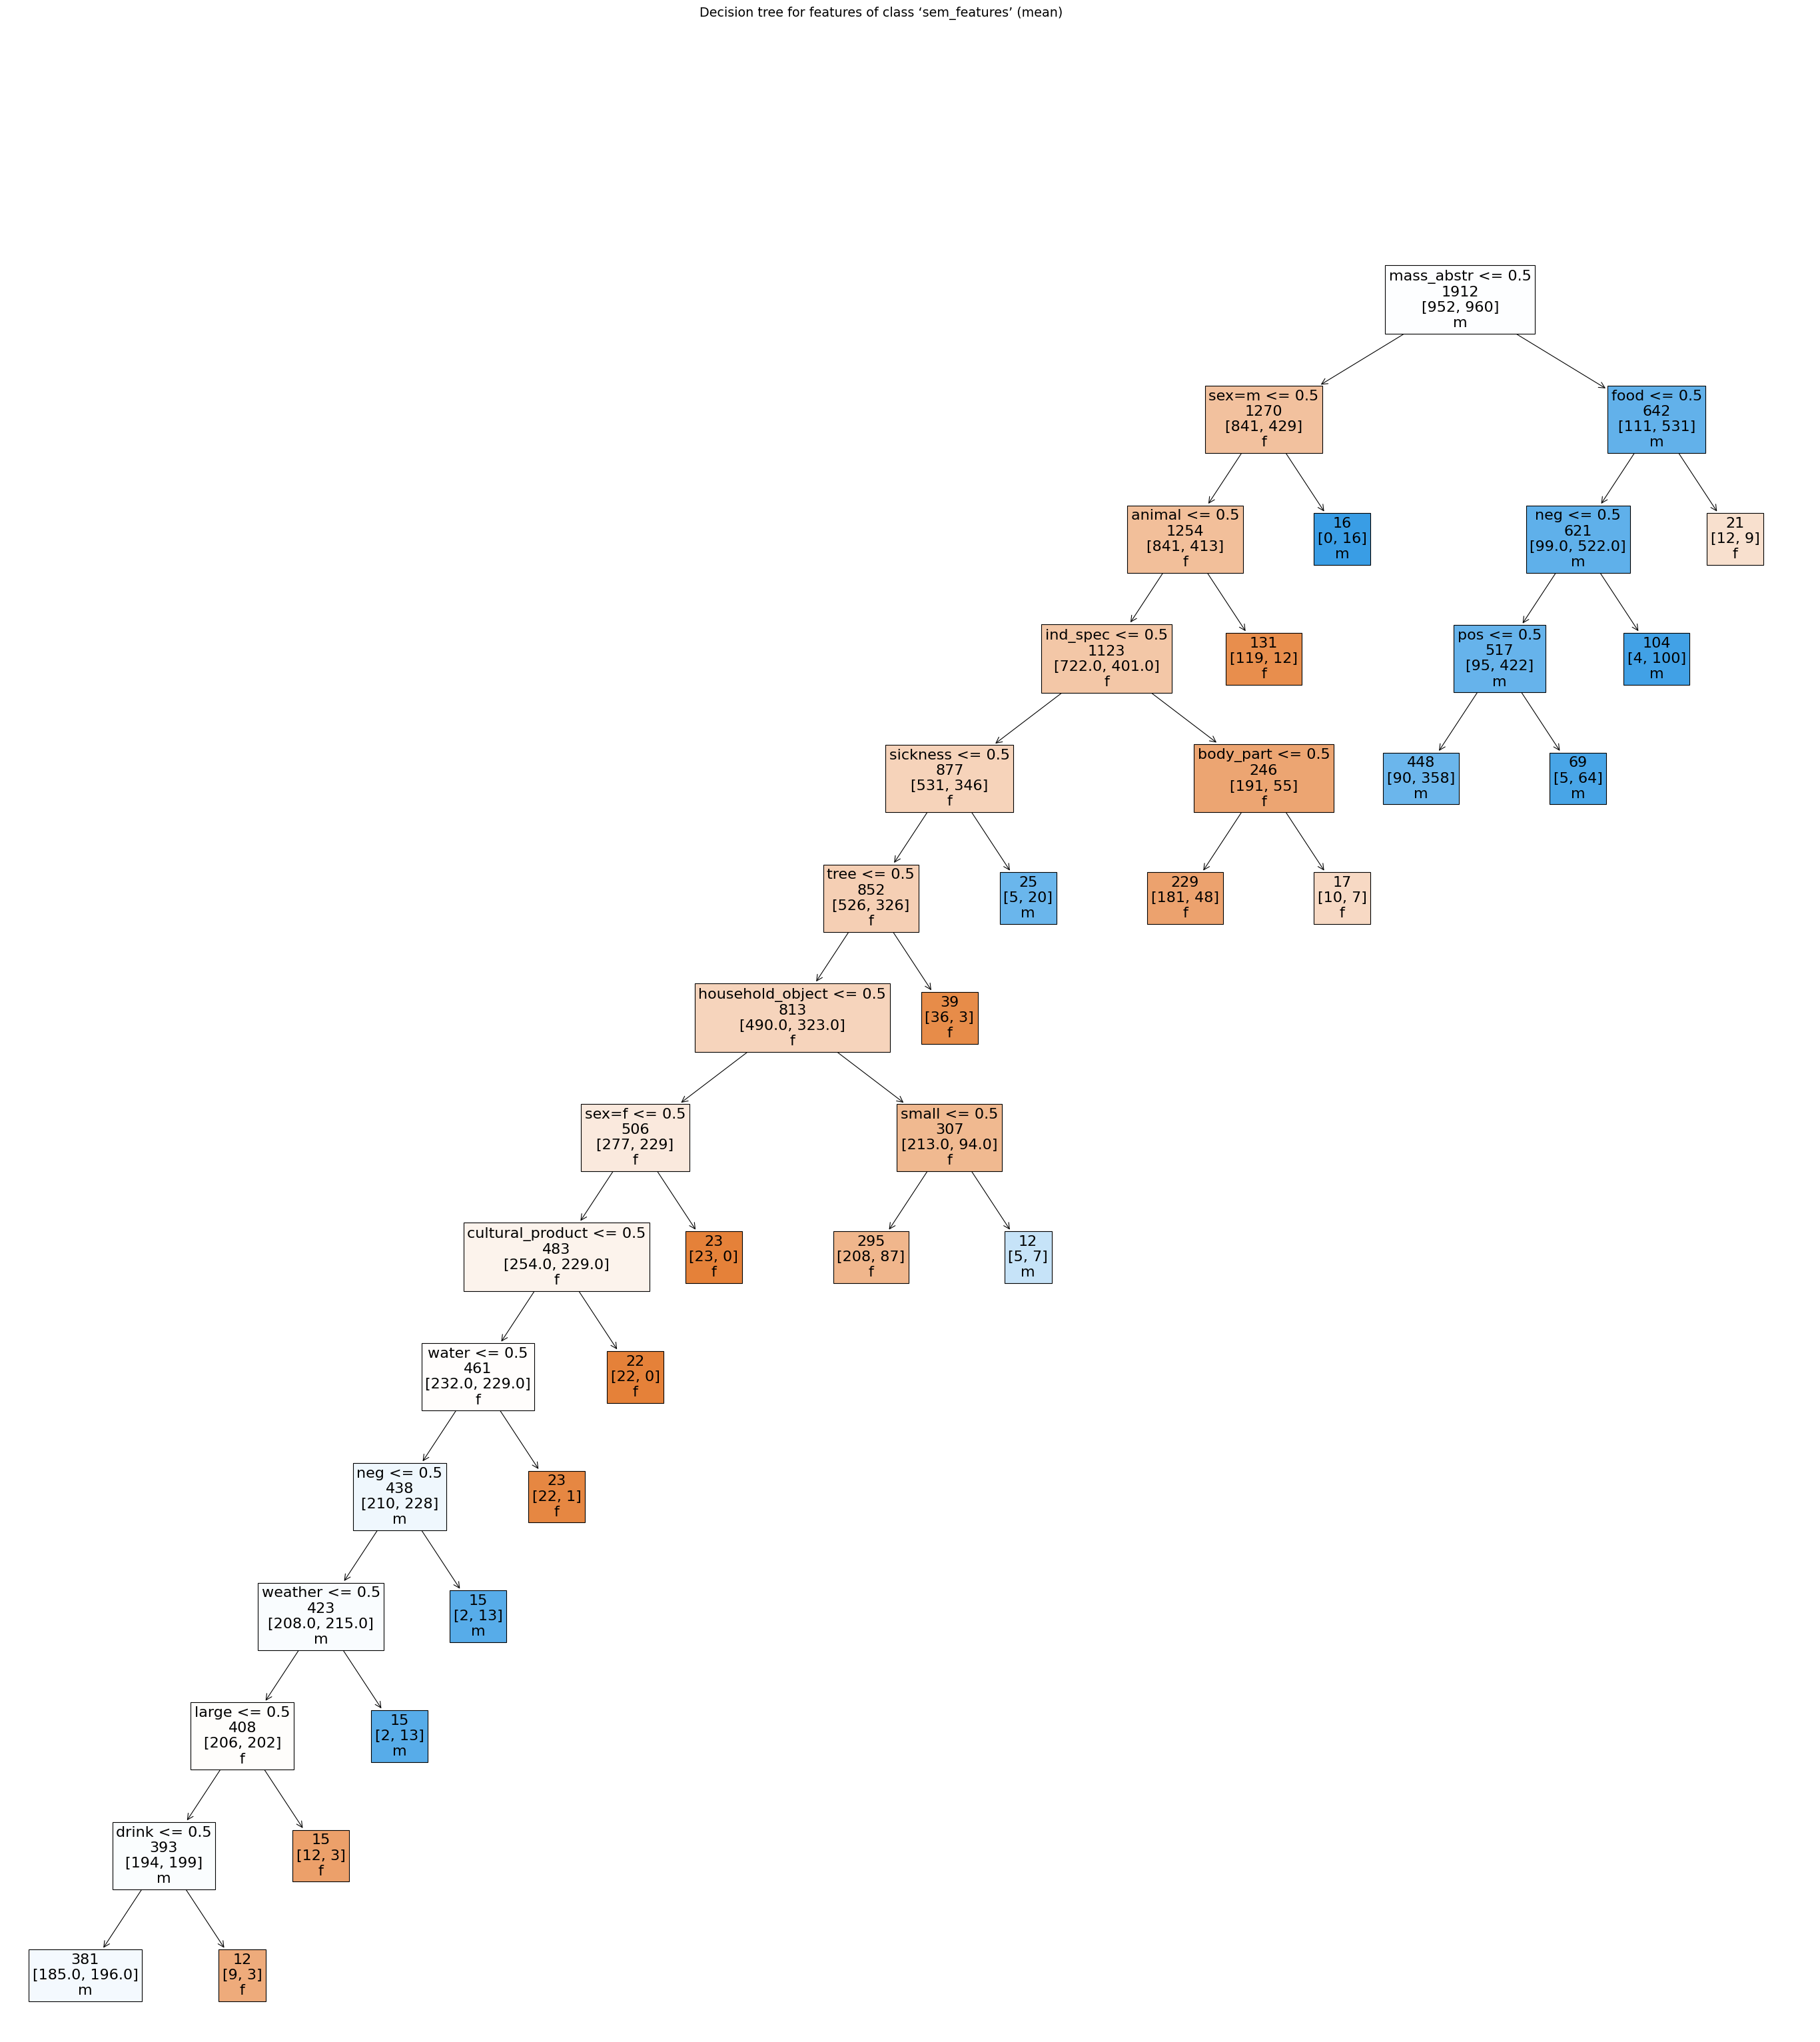

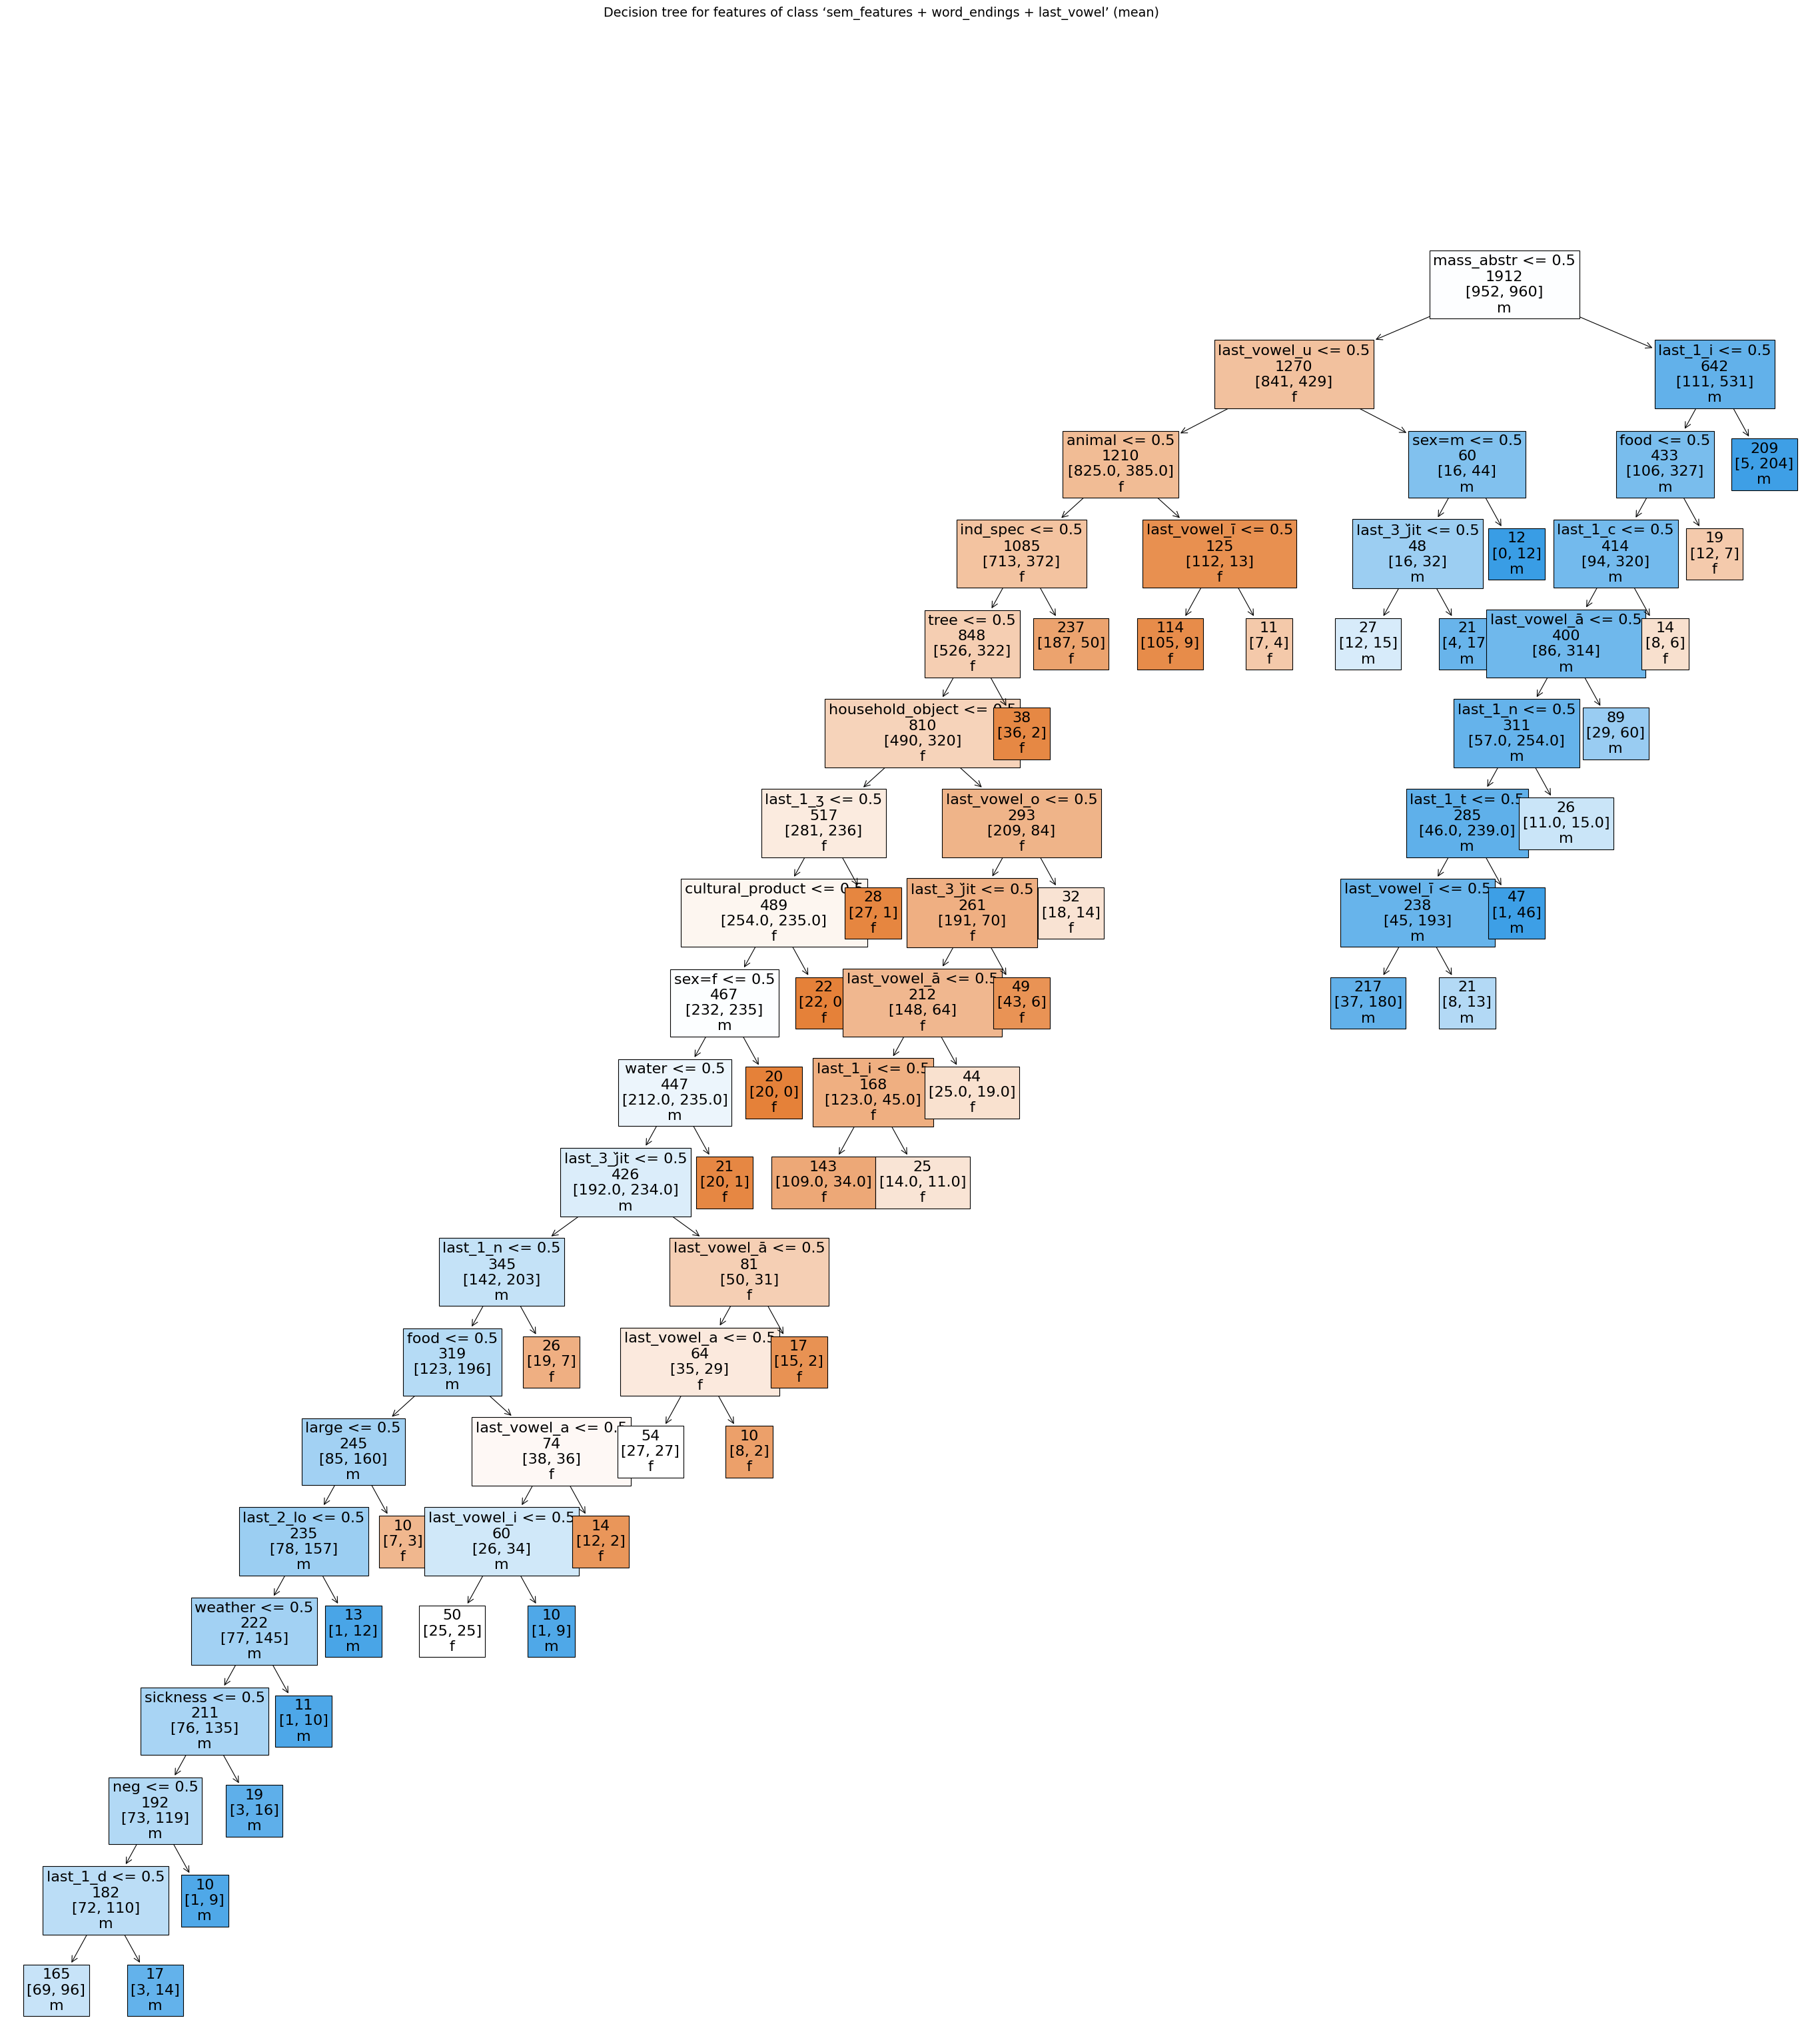

In [51]:
if "DTC" in MODELS_TO_TRAIN:
    for feature in ("word_endings + last_vowel", "sem_features", "sem_features + word_endings + last_vowel",):
        plot_dtc(feature)

### Overlap of predictors

In [62]:
def plot_prediction_correlation(predictions, FEATURE_1, FEATURE_2):
    
    predictions_f = predictions[predictions["meaning_gender"] == "f"]
    predictions_m = predictions[predictions["meaning_gender"] == "m"]
    
    fig, axes = plt.subplots(ncols=2, figsize=(4, 2.5))
    ax1, ax2 = axes

    FEATURE_1, FEATURE_2 = f"pred_{FEATURE_1}", f"pred_{FEATURE_2}"

    sns.heatmap(pd.crosstab(predictions_f[FEATURE_1], predictions_f[FEATURE_2],
                            normalize="all"),
                vmin=0, vmax=1, annot=True, cbar=False, ax=ax1, fmt=".2f")
    sns.heatmap(pd.crosstab(predictions_m[FEATURE_1], predictions_m[FEATURE_2],
                            normalize="all"),
                vmin=0, vmax=1, annot=True, cbar=False, ax=ax2, fmt='.2f')
    ax1.set_title("true feminine"); ax2.set_title("true masculine")
    ax1.set_xlabel(FEATURE_2[5:]); ax2.set_xlabel(FEATURE_2[5:])
    ax1.set_ylabel(FEATURE_1[5:]); ax2.set_ylabel(FEATURE_1[5:])
    fig.suptitle(f"Correlation between predictors (MNB, {len(predictions)} nouns)")
    fig.tight_layout()
    plt.savefig(os.path.join(image_folder, f"predictors_{FEATURE_1[5:]}_{FEATURE_2[5:]}.png"), bbox_inches="tight", dpi=DPI)
    plt.savefig(os.path.join(image_folder, f"predictors_{FEATURE_1[5:]}_{FEATURE_2[5:]}.pdf"), bbox_inches="tight", dpi=DPI)
    plt.show()

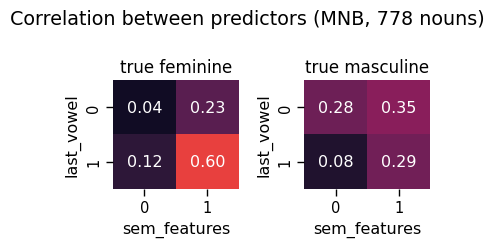

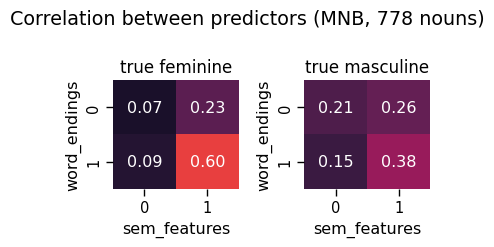

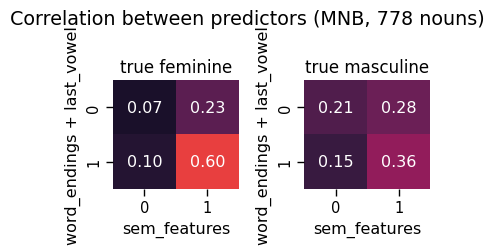

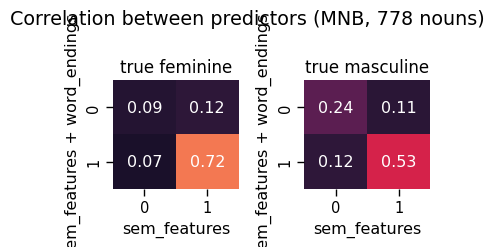

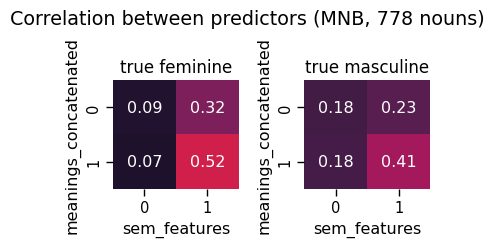

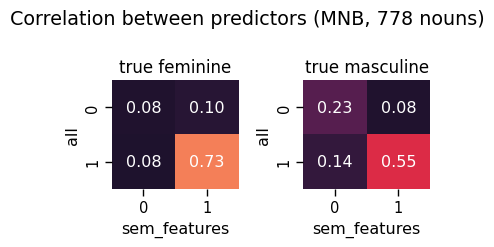

In [63]:
FEATURE_2 = 'sem_features'

for FEATURE_1 in ('last_vowel', 'word_endings', 'word_endings + last_vowel', 'sem_features + word_endings', 'meanings_concatenated', "all"):
    plot_prediction_correlation(predictions, FEATURE_1, FEATURE_2)

### Accuracy across different groups

In [58]:
def accuracy_for_groups(_FEATURES):
    for _FEATURE in _FEATURES:
        filtered = predictions[predictions[_FEATURE] == 1]
        print(_FEATURE)
        correct = len(filtered[filtered["pred_all"] == 1])
        all = len(filtered)
        print(correct, all, round(correct / all, 3), sep="\t", end="\n\n")


accuracy_for_groups(sem_features)

human
5	6	0.833

sex=f
23	23	1.0

sex=m
7	8	0.875

ind_spec
82	105	0.781

mass_abstr
197	243	0.811

large
18	20	0.9

small
39	49	0.796

animal
57	68	0.838

water
15	16	0.938

tree
17	18	0.944

fruit
10	12	0.833

tech_transport
4	4	1.0

cultural_product
15	20	0.75

household_object
139	195	0.713

food
38	48	0.792

drink
8	9	0.889

plant
30	49	0.612

event
12	17	0.706

pos
29	31	0.935

neg
50	53	0.943

weather
6	8	0.75

body_part
12	22	0.545

building
11	24	0.458

landscape
30	42	0.714

diary_product
6	7	0.857

sickness
13	16	0.812

